# Badanie czynników wpływających na wyniki w nauce
### Autor: Maria Mikołajczak


## 1. Informacje o zbiorze danych
+ **Autorzy**: Elaf Abu Amrieh, Thair Hamtini, and Ibrahim Aljarah, The University of Jordan, Amman, Jordan, http://www.Ibrahimaljarah.com
www.ju.edu.jo
+ **Sposób zebrania danych:** Dane pochodzą z obserwacji, z programu typu learning management system (Kallboard 360). Jest to program, który został zaprojektowany w celu ułatwienia procesu uczenia się w trybie online. Głownym celem systemu LMS jest monitorowanie postępów w nauce i uczestnictwa w zajęciach. Dane na temat fukncji behawioralnych zostały zgromadzone za pomocą specjalnego komponentu do monitorowania aktywności ucznia- xAPI. Narzędzie to pozwala między innymi monitorować zachowanie uczącego się takie jak czytanie materiałów czy oglądanie filmów edukacyjnych.
+ **Odniesienia** (autorzy zbioru danych proszą, aby dodać odniesienie do ich opracowań w przypadku skorzystania z danych):
    + Amrieh, E. A., Hamtini, T., & Aljarah, I. (2016). Mining Educational Data to Predict Student’s academic Performance using Ensemble Methods. International Journal of Database Theory and Application, 9(8), 119-136.
    + Amrieh, E. A., Hamtini, T., & Aljarah, I. (2015, November). Preprocessing and analyzing educational data set using X-API for improving student's performance. In Applied Electrical Engineering and Computing Technologies (AEECT), 2015 IEEE Jordan Conference on (pp. 1-5). IEEE.
  

In [1]:
data <- read.csv("./xAPI-Edu-Data.csv",  stringsAsFactors = TRUE)

#### Dodatki do wizualizacji i analizy

In [2]:
suppressMessages(library(e1071)) 
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library(caret))
library(nnet)
w=13
h=8
options(repr.plot.width=w, repr.plot.height=h)

center_title <- theme(plot.title = element_text(hjust = 0.5))

## 2. Ogólna charakterystyka danych
+ Liczność próby- **480** uczniów z różnych krajów
+ Dane obejmują pomiar 16 cech, które można podzielić na trzy główne kategorie:
    1. **cechy demograficzne** (np. narodowość płeć, pochodzenie)
    2. **podstawowe cechy na temat edukacji** (np. etap edukacji, główny temat kursu)
    3. **funkcje behawioralne** (np. liczba podniesień ręki w czasie lekcji, wyniki ankiety dla rodziców)
+ Ostatnia, siedemnasta kolumna danych to przydział do jednego z trzech interwałów według całkowitej oceny:
    * Low (L) - [0,69]
    * Middle (M)- [70, 89]
    * High (H)- [90, 100]

In [3]:
n=480
str(data)

'data.frame':	480 obs. of  17 variables:
 $ gender                  : Factor w/ 2 levels "F","M": 2 2 2 2 2 1 2 2 1 1 ...
 $ NationalITy             : Factor w/ 14 levels "Egypt","Iran",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ PlaceofBirth            : Factor w/ 14 levels "Egypt","Iran",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ StageID                 : Factor w/ 3 levels "HighSchool","lowerlevel",..: 2 2 2 2 2 2 3 3 3 3 ...
 $ GradeID                 : Factor w/ 10 levels "G-02","G-04",..: 2 2 2 2 2 2 5 5 5 5 ...
 $ SectionID               : Factor w/ 3 levels "A","B","C": 1 1 1 1 1 1 1 1 1 2 ...
 $ Topic                   : Factor w/ 12 levels "Arabic","Biology",..: 8 8 8 8 8 8 9 9 9 8 ...
 $ Semester                : Factor w/ 2 levels "F","S": 1 1 1 1 1 1 1 1 1 1 ...
 $ Relation                : Factor w/ 2 levels "Father","Mum": 1 1 1 1 1 1 1 1 1 1 ...
 $ raisedhands             : int  15 20 10 30 40 42 35 50 12 70 ...
 $ VisITedResources        : int  16 20 7 25 50 30 12 10 21 80 ...
 $ Announcements

W celu ułatwienia analizy zbioru danych modyfikuje nazwy kolumn, tak aby były one bardziej intuicyjne i miały ujednoliconą formę: 

In [4]:
colnames(data)<- c('Gender', 'Nationality', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID','Topic', 'Semester','Guardian', 'RaisedHand',
    'VisitedResources', 'AnnouncementsViews', 'DiscussionGroups', 'ParentSurvey','ParentSchoolSatisfaction', 'AbsenceDays', 'GradeClass') 

Ponadto, sortuję cechy wyrażone w skali porządkowej, tak aby kolejność była intuicyjna:

In [5]:
data$GradeClass <- factor(data$GradeClass, levels = c("L", "M", "H"), ordered=TRUE)
data$StageID <- factor(data$StageID, levels = c("lowerlevel", "MiddleSchool", "HighSchool"), ordered=TRUE)

### Objaśnienie atrybutów:
1. `Gender`- płeć ucznia, cecha jakościowa: *M- mężczyzna, F- kobieta*
2. `Nationality`- narodowość ucznia, cecha jakościowa: np. *Kuwait, Lebanon, Venezuela*
3. `PlaceofBirth`- kraj, w którym urodził się uczeń, cecha jakościowa analogiczna to `Nationality`
4. `StageID`- identyfikator poziomu edukacji, cecha jakościowa: *lowerlevel, Middleschool, Highschool*
5. `GradeID`- identyfikator roku, na którym jest uczeń, cecha jakościowa: *G-01, G-02,..., G-12*
6. `SectionID`- "sala lekcyjna", do której przynależy uczeń, cecha jakościowa: *A, B, C*
7. `Topic`- nazwa głównego realizowanego przedmiotu, cecha jakościowa: np. *English, Spanish, IT*
8. `Semester`- numer semestru, cecha jakościowa: *F- pierwszy, S-drugi*
9. `Guardian`- opiekun prawny, rodzic odpowiedzialny, cecha jakościowa: *mom, father*
10. `RaisedHand`- liczba razy, kiedy uczeń "podniósł rękę", czyli zgłosił chęć wypowiedzi podczas zajęć, cecha ilościowa dyksretna: *0-100*
11. `VisitedResources`- wyraża liczbę razy, kiedy uczeń odwiedził stronę przedmiotu z materiałami edukacyjnymi, cecha ilościowa dyskretna: *0-100*
12. `AnnouncementsViews`- wyraża liczbę razy, kiedy uczeń sprawdzał bieżące ogłoszenia, cecha ilościowa dyksretna: *0-100*
13. `DiscussionGroups`- wyraża liczbę razy, kiedy uczeń uczestniczył w grupie dyskusyjnej, cecha ilościowa dyskretna: *0-100*
14. `ParentSurvey`- informacja, czy rodzic odpowiedzialny (`Guardian`) wypełnił ankietę, cecha jakościowa: *Yes, No*
15. `ParentSchoolSatisfaction`- stopień zadowolenia rodzica z poziomu placówki edukacyjnej, cecha jakościowa: *above-7, under-7*
16. `AbsenceDays`- liczba dni, kiedy uczeń był nieobecny, cecha jakościowa: *above-7, under-7*
17. `GradeClass`- klasa całkowitej oceny ucznia. Cecha została opisana już powyżej.

## 3. Eksploracyjna analiza danych

##### Funkcje pomocnicze:

In [6]:
get_perc <- function(df_col, round=2){
    count <- table(df_col)
    perc <- round(as.vector(count[1:length(count)])*100/length(df_col), digits=round)
}

change_opt <- function(height, width){
    options(repr.plot.width=width, repr.plot.height=height)
}

undo_opt <- function(){
    options(repr.plot.width=w, repr.plot.height=h)
}


get_count <- function(df, name1, name2="Count", d=TRUE){
    df_c <- data.frame(table(df[name1]))
    colnames(df_c) <- c(name1, name2)
    df_c1 <- df_c[order(-df_c[name2]),]
    
}

In [7]:
hist_mean <- function(df, n=30, iter=10000){
    sample_means<-rep(NA, n)
    for(i in 1:iter){
        samp <- sample(df, n, replace=TRUE)
        sample_means[i] <- mean(samp)
    }
    
    hist(sample_means)
}


qq_mean <- function(df, n=30, iter=10000){
    sample_means<-rep(NA, n)
    for(i in 1:iter){
        samp <- sample(df, n, replace=TRUE)
        sample_means[i] <- mean(samp)
    }
    
    qqnorm(sample_means)
    qqline(sample_means)
}



### 3.1 Analiza ogólnej struktury próbki danych
Zacznijmy analizę od bliższego przyjrzenia się strukturze zbioru danych. Pomoże to ukierunkować dalszą analizę i wykryć ewentualne anomalie w danych.

In [8]:
c <- sapply(data, is.nan)
length(c[c==TRUE])

[1] 0

##### Wnioski i spostrzeżenia
+ Nie ma żadnych wartości pustych w zbiorze danych. 

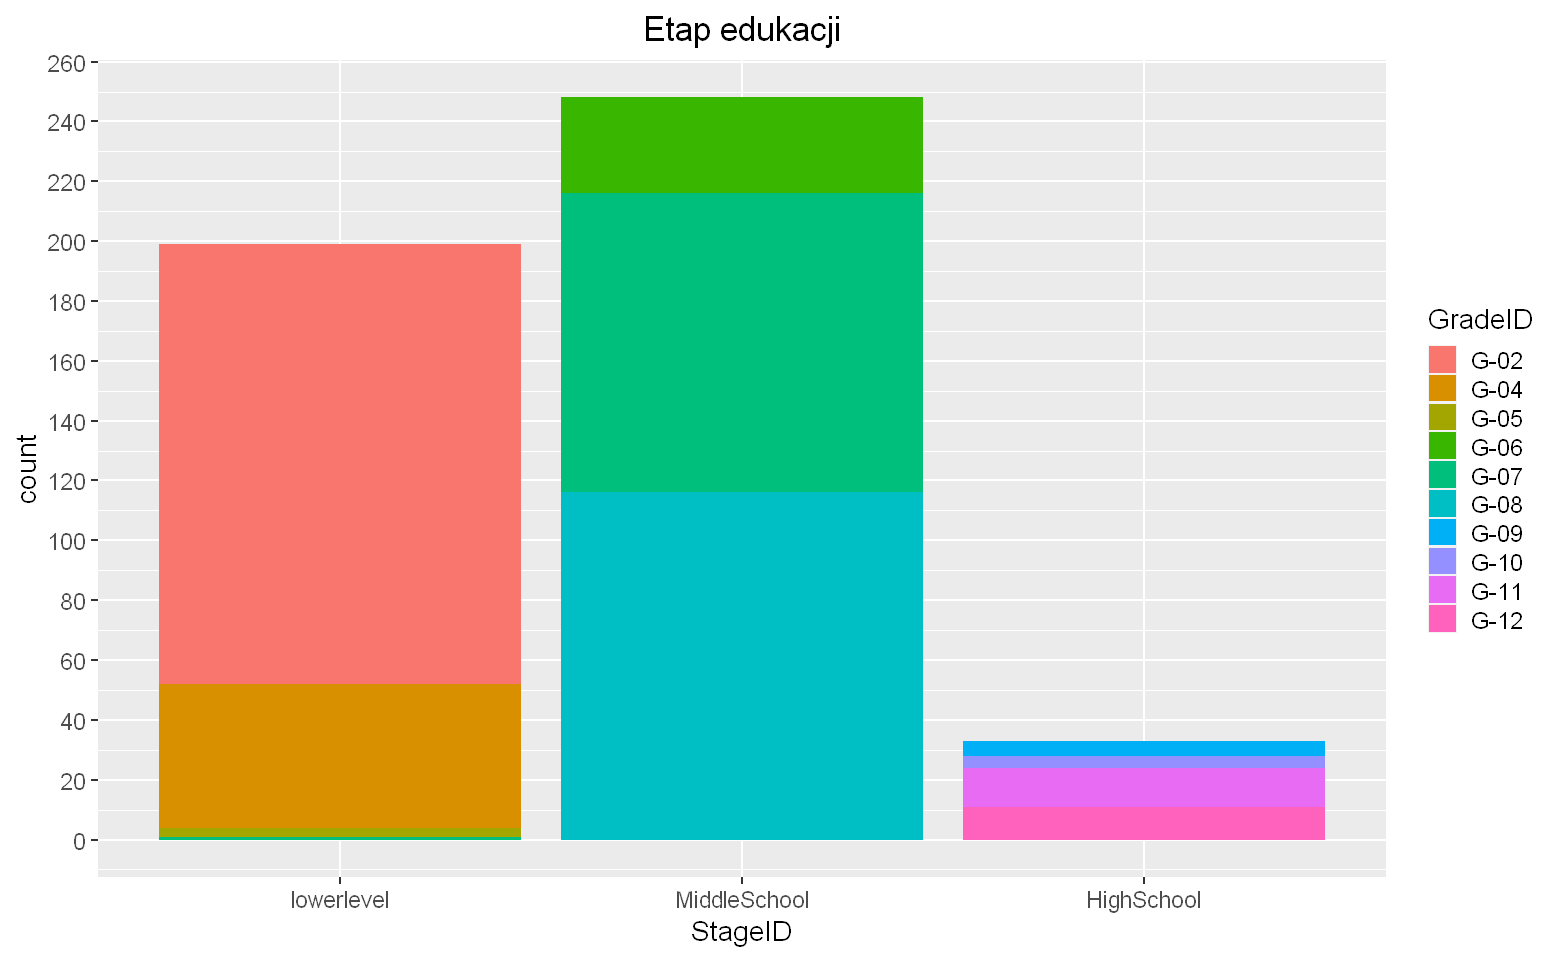

In [9]:
plot <- ggplot(data, aes(x=StageID, fill=GradeID)) + geom_bar()
plot<- plot + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,260,20))
plot <- plot + ggtitle("Etap edukacji") + center_title 

plot

##### Spostrzeżenia i wnioski:
+ Dane dotyczą głównie uczniów z poziomu edukacji gimnazjalnego- *MiddleSchool* (248 uczniów) oraz z poziomu niższego niż gimnazjalny (podstawówka itp.)- *lowerlevel* (199). 
+ Licznośc uczniów na poziomie licealnym to 33 jednostki.

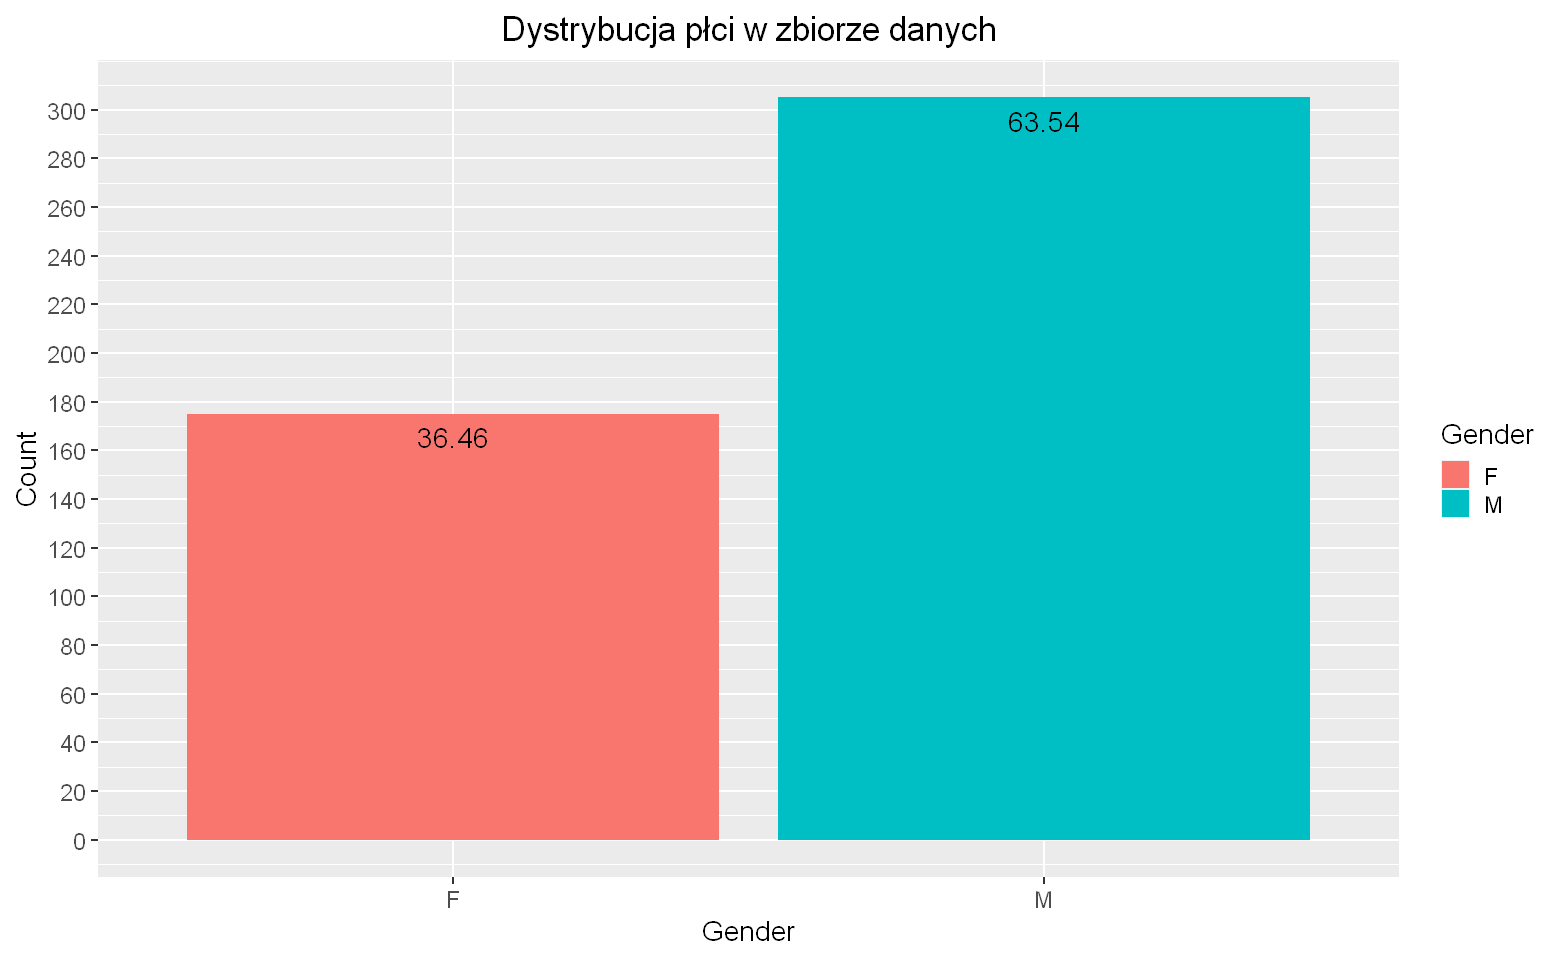

In [10]:
gender <- data.frame(table(data$Gender))
colnames(gender) <- c("Gender", "Count")
gender_perc <- get_perc(data$Gender)

plotg <- ggplot(gender, aes(x=Gender, y=Count, fill=Gender)) + geom_bar(stat='identity') 
plotg <- plotg + geom_text(aes(label=gender_perc), vjust=1.6, size=6) + scale_y_continuous(breaks=seq(0,300,20)) 
plotg<- plotg + ggtitle("Dystrybucja płci w zbiorze danych")+ theme_gray(base_size=17) + center_title

plotg

##### Spostrzeżenia i wnioski:
+ 36.46% uczniów jest płci żeńskiej, a 63.54% płci męskiej.

,Nationality,Count
,<fct>,<int>
5,KW,179
4,Jordan,172
9,Palestine,28
3,Iraq,22
6,lebanon,17
12,Tunis,12
10,SaudiArabia,11
1,Egypt,9
11,Syria,7


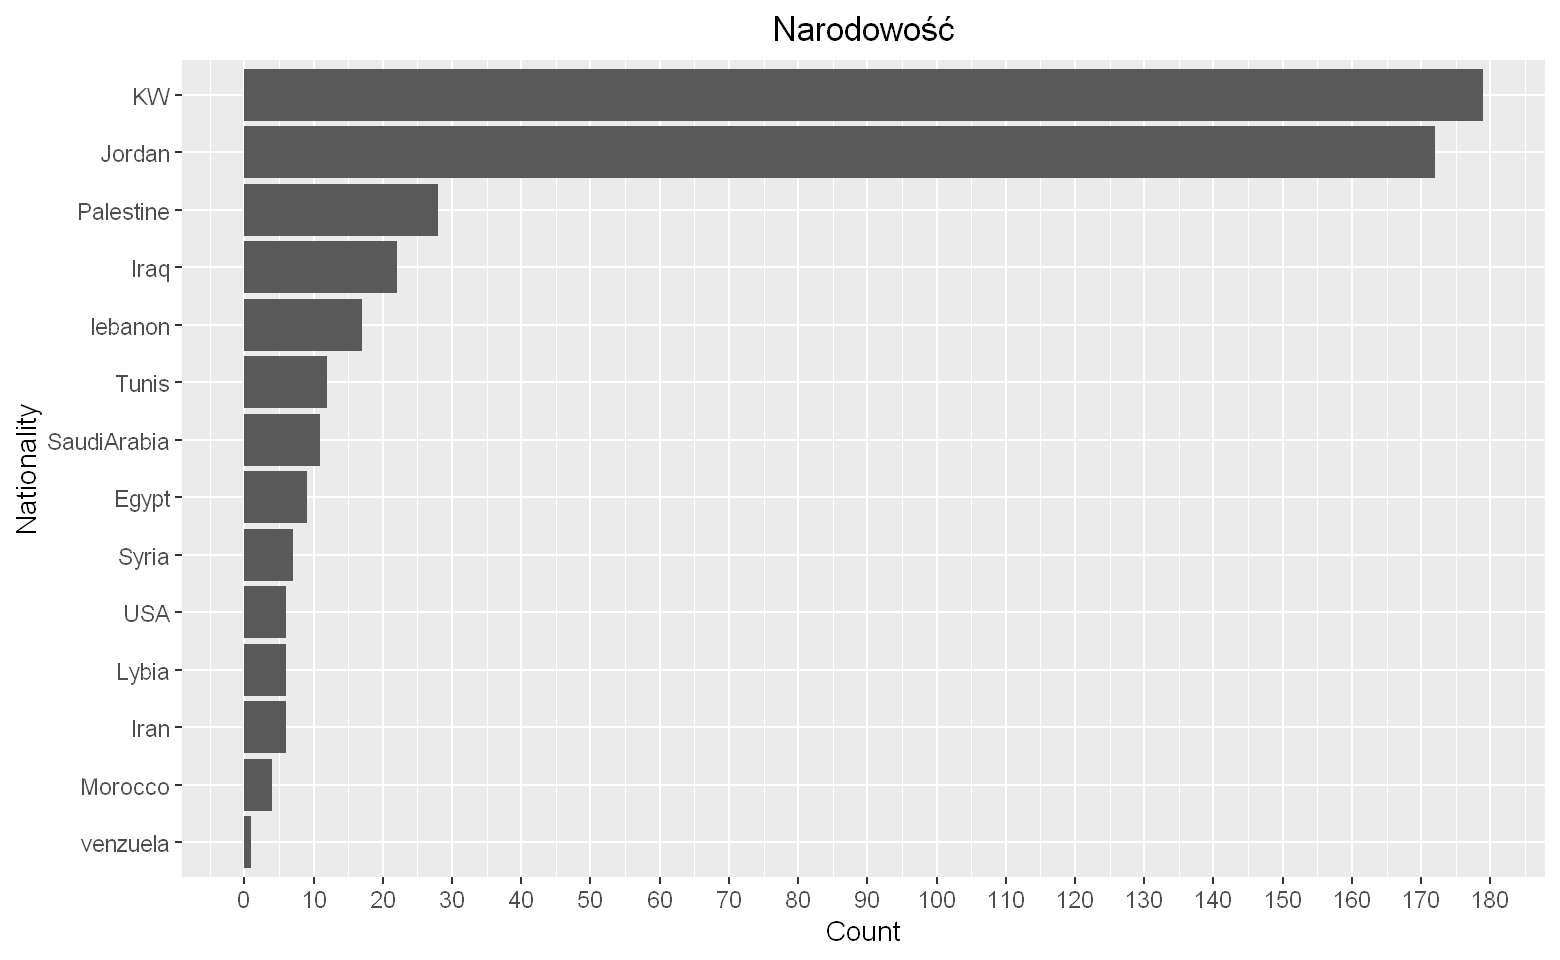

In [11]:
nat_count <- get_count(data, "Nationality")
nat_count

plot <- ggplot(nat_count, aes(reorder(Nationality, Count), Count)) + geom_bar(stat='identity') 
plot<- plot + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,200,10)) + coord_flip()
plot <- plot + ggtitle("Narodowość") + center_title + xlab("Nationality")

plot

##### Spostrzeżenia i wnioski:
+ Najwięcej uczniów pochodzi z Kuwejtu i Jordanii- jest to odpowiednio 179 i 172 uczniów.
+ Liczba uczniów z pozostałych krajów jest o wiele niższa- żaden inny kraj nie przekracza 30 jednostek.
+ Taka konkretna różnorodność kulturowa może mieć wpływ na wyniki uczniów.
+ Duża przewaga dwóch krajów sprawia, że przy ewentualnym wnioskowaniu statystycznym należałoby rozważyć wpływ danego regionu kulturowego na wyniki.

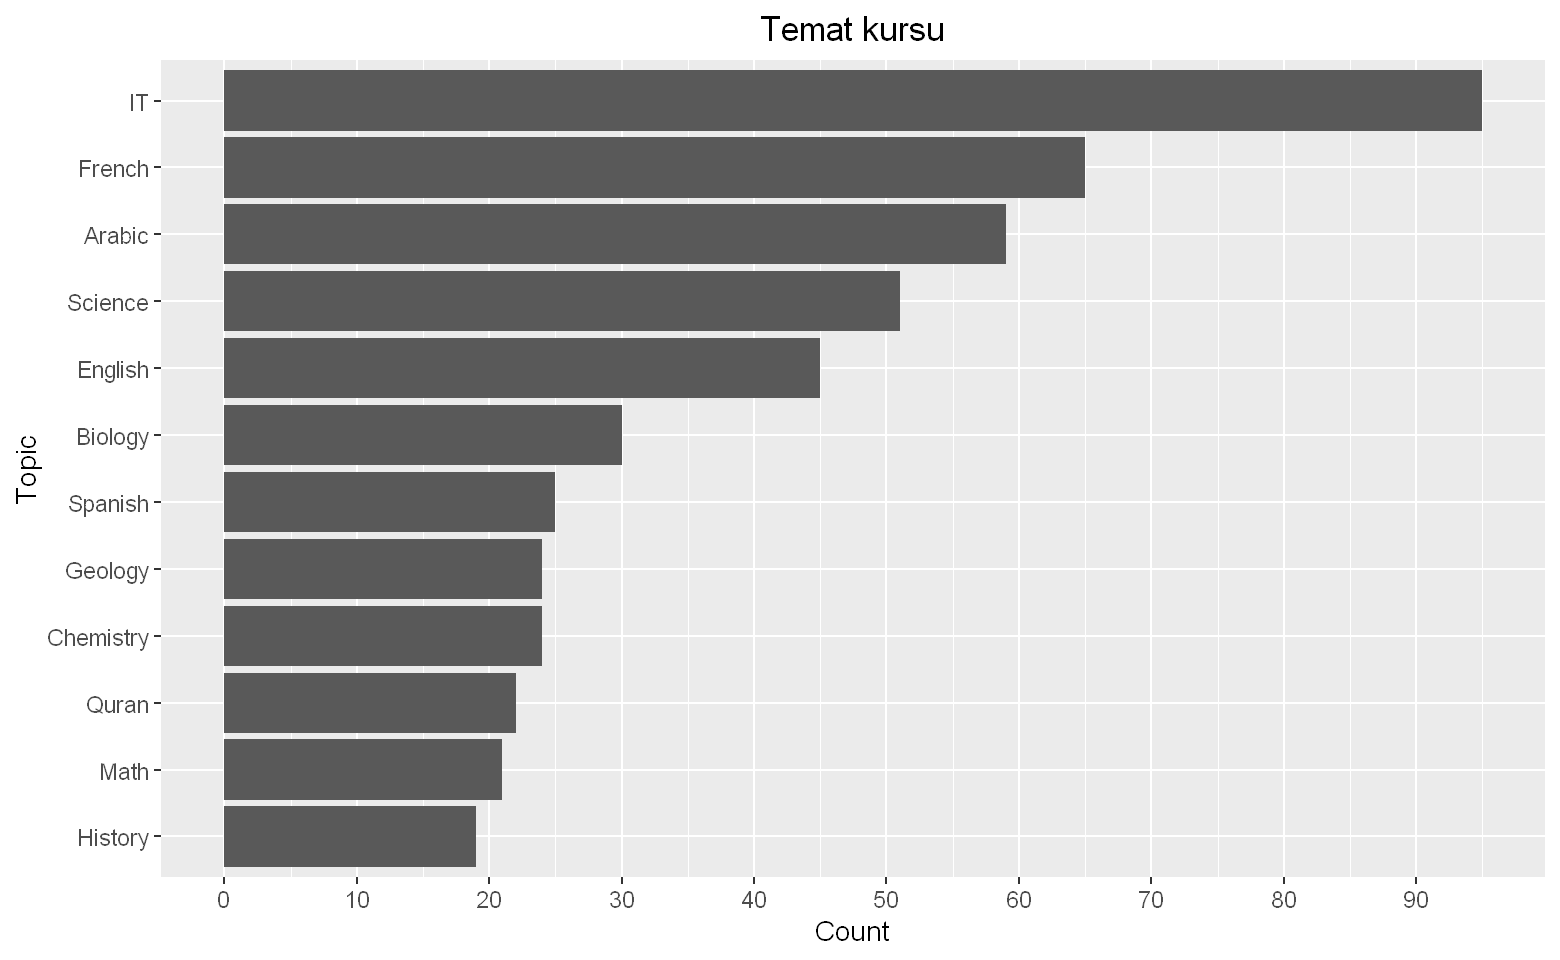

In [12]:
topic_count <- get_count(data, "Topic")
p1 <- ggplot(topic_count, aes(reorder(Topic, Count), Count)) + geom_bar(stat='identity') + xlab("Topic")
p1 <- p1 + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,200,10)) + coord_flip() + ggtitle("Temat kursu") + center_title

p1

##### Spostrzeżenia wnioski
+ Najwięcej uczniów z badanego zbioru danych realizuje jako główny przedmiot technologie informatyczne. 
+ Na drugim miejscu plasują się jezyki: francuski i arabski.

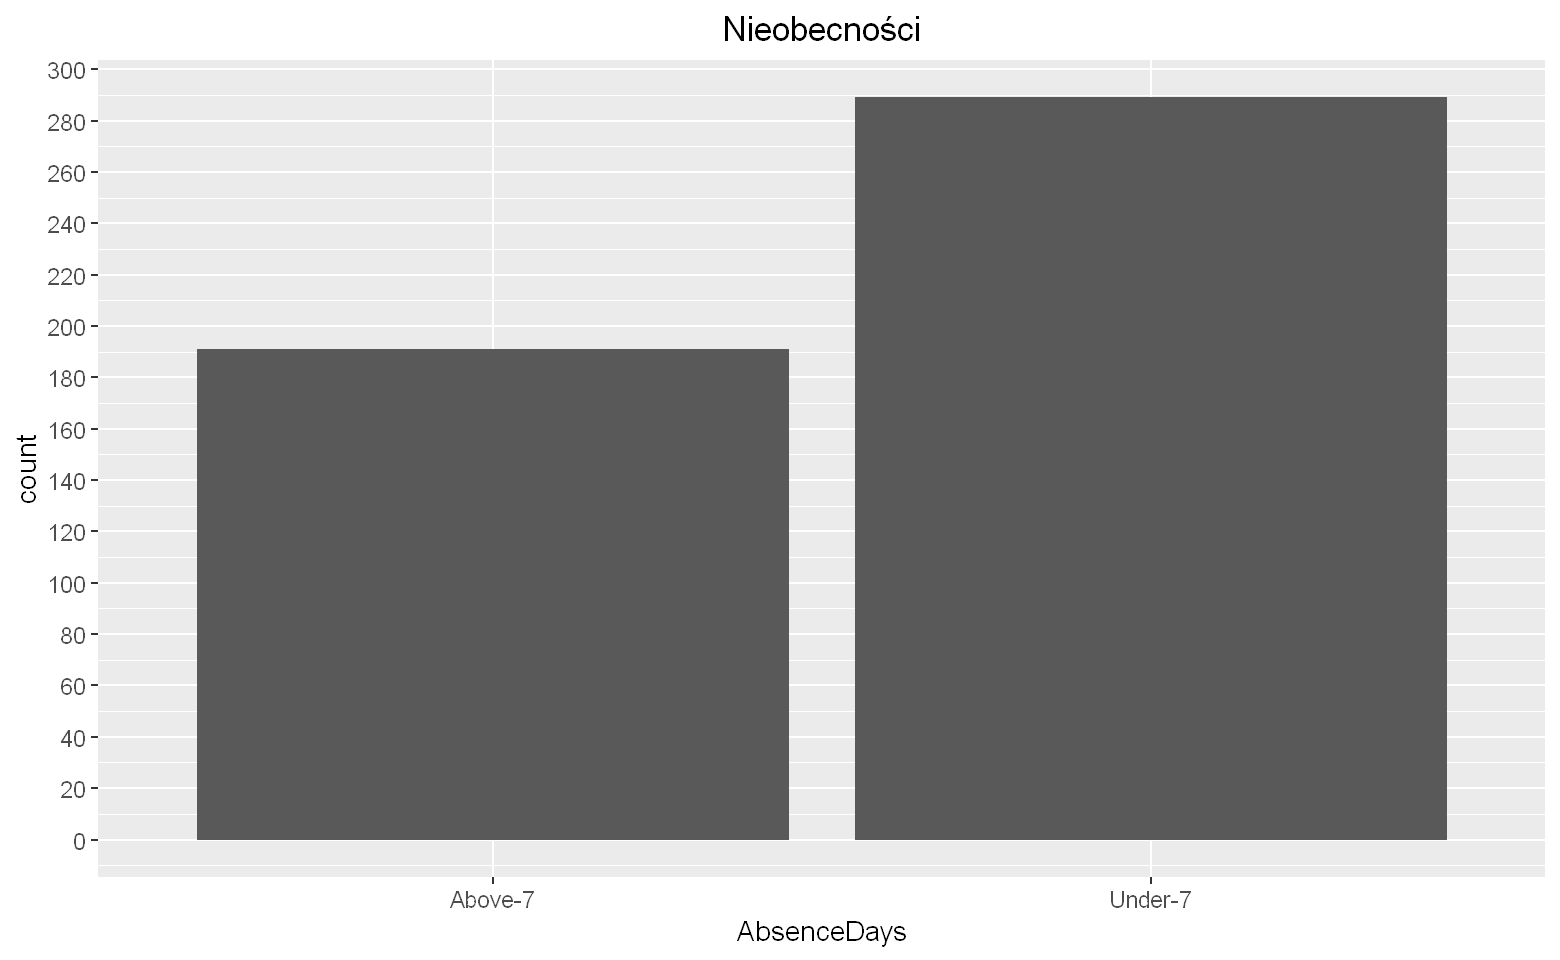

In [13]:

p1 <- ggplot(data, aes(AbsenceDays)) + geom_bar() 
p1 <- p1 + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,300,20)) + ggtitle("Nieobecności") + center_title

p1

##### Spostrzeżenia i wnioski
+ Większość uczniów ma mniej niż siedem dni nieobecności.
+ Około 40% uczniów opuściło więcej niż siedem dni.

### 3.2 Analiza różnic między płciami
Analizowana próbka danych zawiera dane o obu płciach w potencjalnie wystarczającej ilości, aby badać różnice w procesie uczenia się między płciami. Możemy na przykład sprawdzić czy istnieje jakaś różnica między płciami w wyborze tematu kursu:

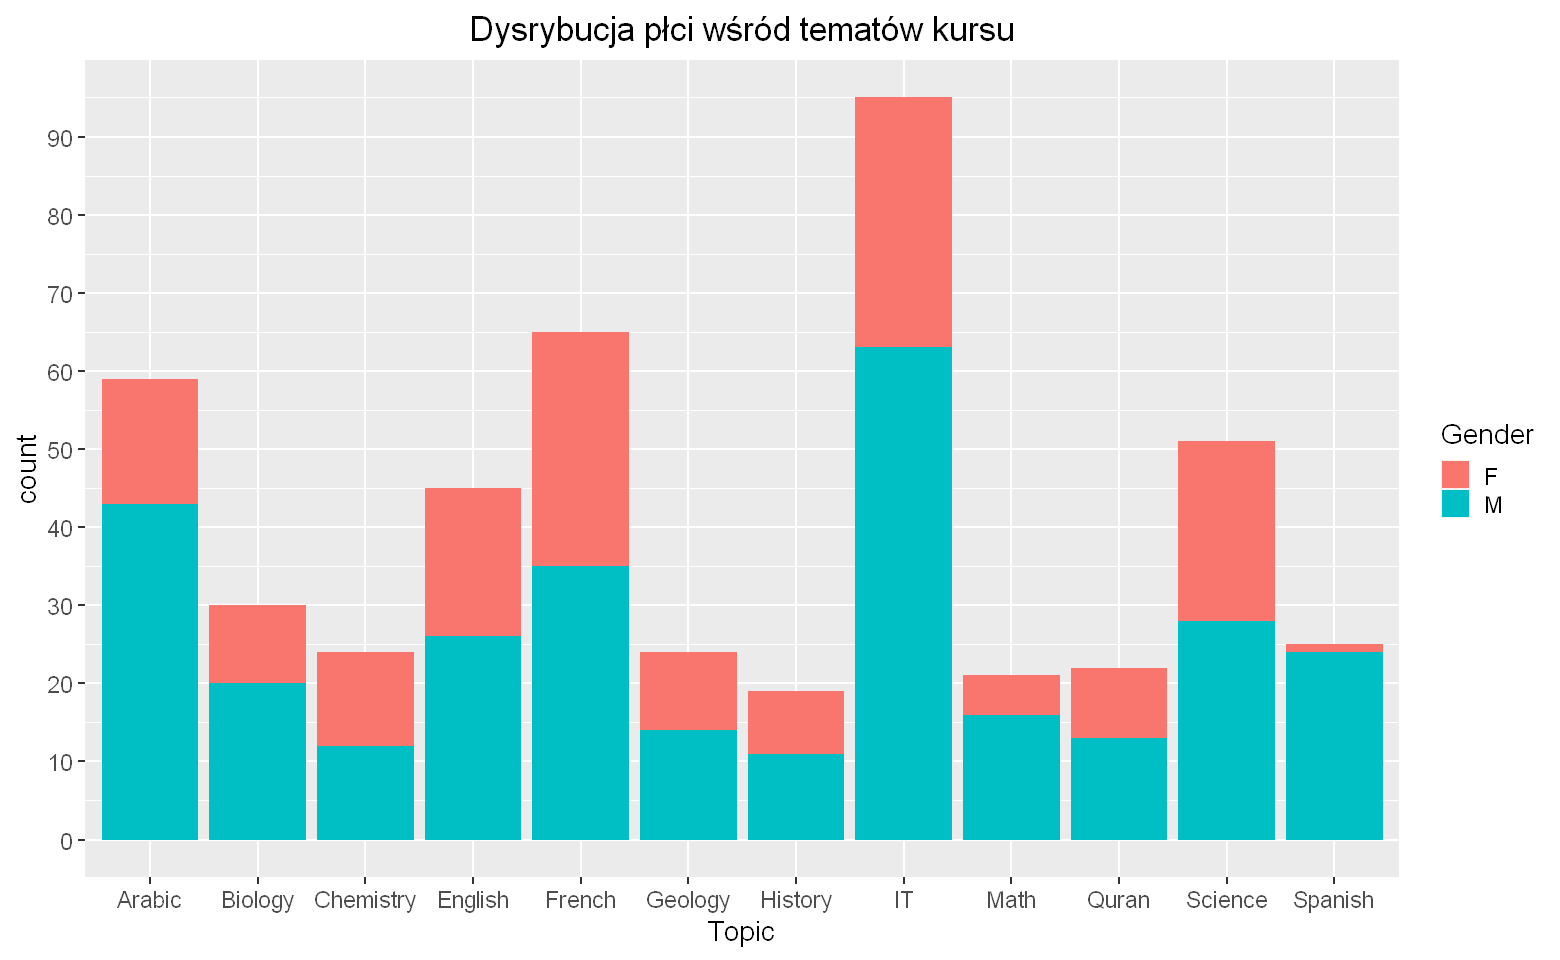

In [14]:
plot<- ggplot(data, aes(x = Topic, fill=Gender)) + geom_bar() + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,110,10)) 
plot <- plot + ggtitle("Dysrybucja płci wśród tematów kursu") + center_title

plot

##### Spostrzeżenia i wnioski
+ Stosunek płci żeńskiej do płci męskiej w każdym z tematów wydaje się być naturalny, biorąc pod uwagę, że dziewczyny stanowią jedynie $\approx 36\%$ próbki danych.
+ Język hiszpański (`Spanish`) to kurs, który ma najmniejszy stosunek płci żeńskiej do męskiej, jednak liczność uczniów ogólnie wybierających ten kurs jest za mała, aby efektywnie przeprowadzić dalszą analizę tego zjawiska.

Nie udało się wykryć jakiejś szczególnej tendencji w wyborze kursu w zależności od płci, ale możemy zbadać, czy istnieje jakaś różnica w sposobie uczenia się między płciami. Sprawdźmy najpierw, czy rozklad płci na poziomach edukacji jest w miarę równy (aby wykluczyć sytuację, kiedy dziewczyny stanowiłyby np. 100% uczniów na którymś z poziomów):

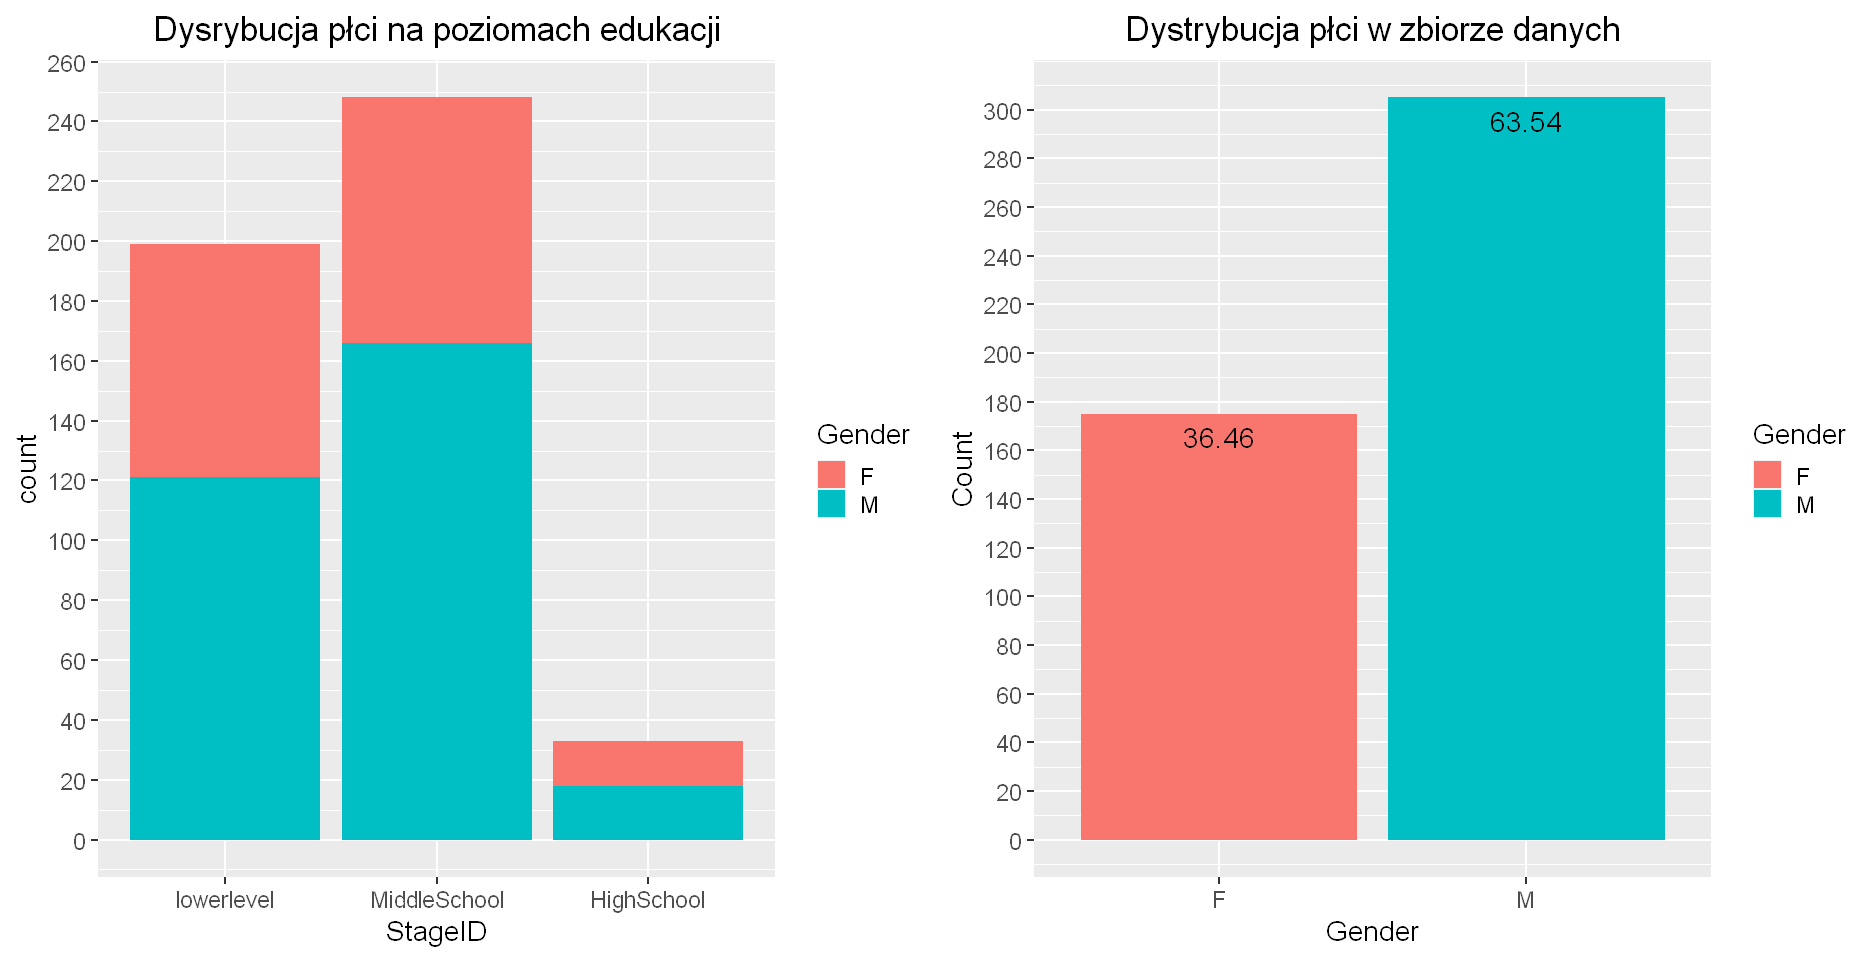

In [15]:
plot1<- ggplot(data, aes(x = StageID, fill=Gender)) + geom_bar() + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,300,20)) 
plot1<- plot1 + ggtitle("Dysrybucja płci na poziomach edukacji") + center_title

change_opt(h, 1.2*w)
grid.arrange(plot1, plotg, ncol=2)
undo_opt()

##### Spostrzeżenia i wnioski
+ Stosunek płci żeńskiej do męskiej na poziomach edukacji jest podobny.

Możemy więc zbadać jak różni się sposób uczenia się pomiedzy płciami:

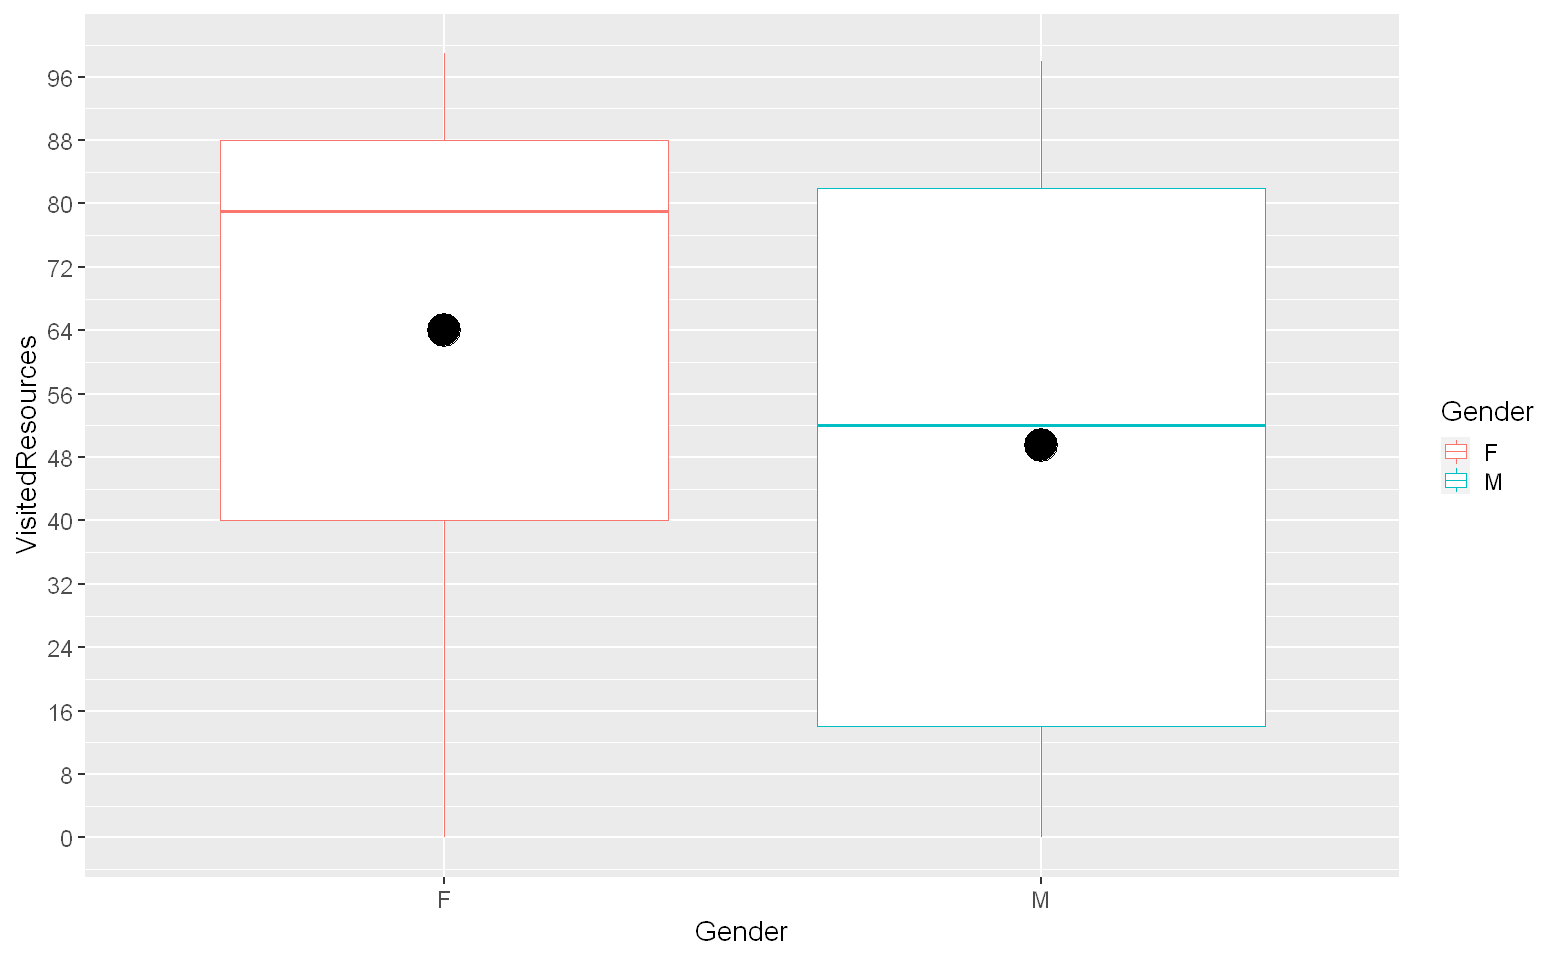

In [16]:
ggplot(data, aes(x=Gender, y=VisitedResources, color=Gender)) + 
  geom_boxplot(outlier.size=4)  + scale_y_continuous(breaks = seq(0,100,8)) +theme_gray(base_size=17) + stat_summary(fun=mean, geom="point", shape=20, size=14, color="black", fill="black")

##### Spostrzeżenia i wnioski
(Czarny punkt wskazuje wartość średnią badanej cechy)
+ Dziewczyny średnio większą ilość razy niż chłopcy korzystają z materiałów edukacyjnych
+ Odstęp międzykwartylowy ($IQR$) w próbce dziewczyn jest mniejszy niż w próbce chłopców. W obrębie $IQR$ znajduje sie 50% wartości badanej cechy, więc w próbce dla płci męskiej możemy spodziewać się większego rozproszenia badanej cechy. Natomiast ogólny rozstęp cechy jest nieco większy w grupie dziewczyn, ale jest to spowodowane niewieloma obserwacjami odstającymi. 
+ W obu próbkach nie ma obserwacji odstających od mediany na więcej niż $1.5 \cdot IQR$.

Narysujmy jeszcze histogramy dla badanych cech:

  Gender   Skewness
1      F -0.7821284
2      M -0.1039666


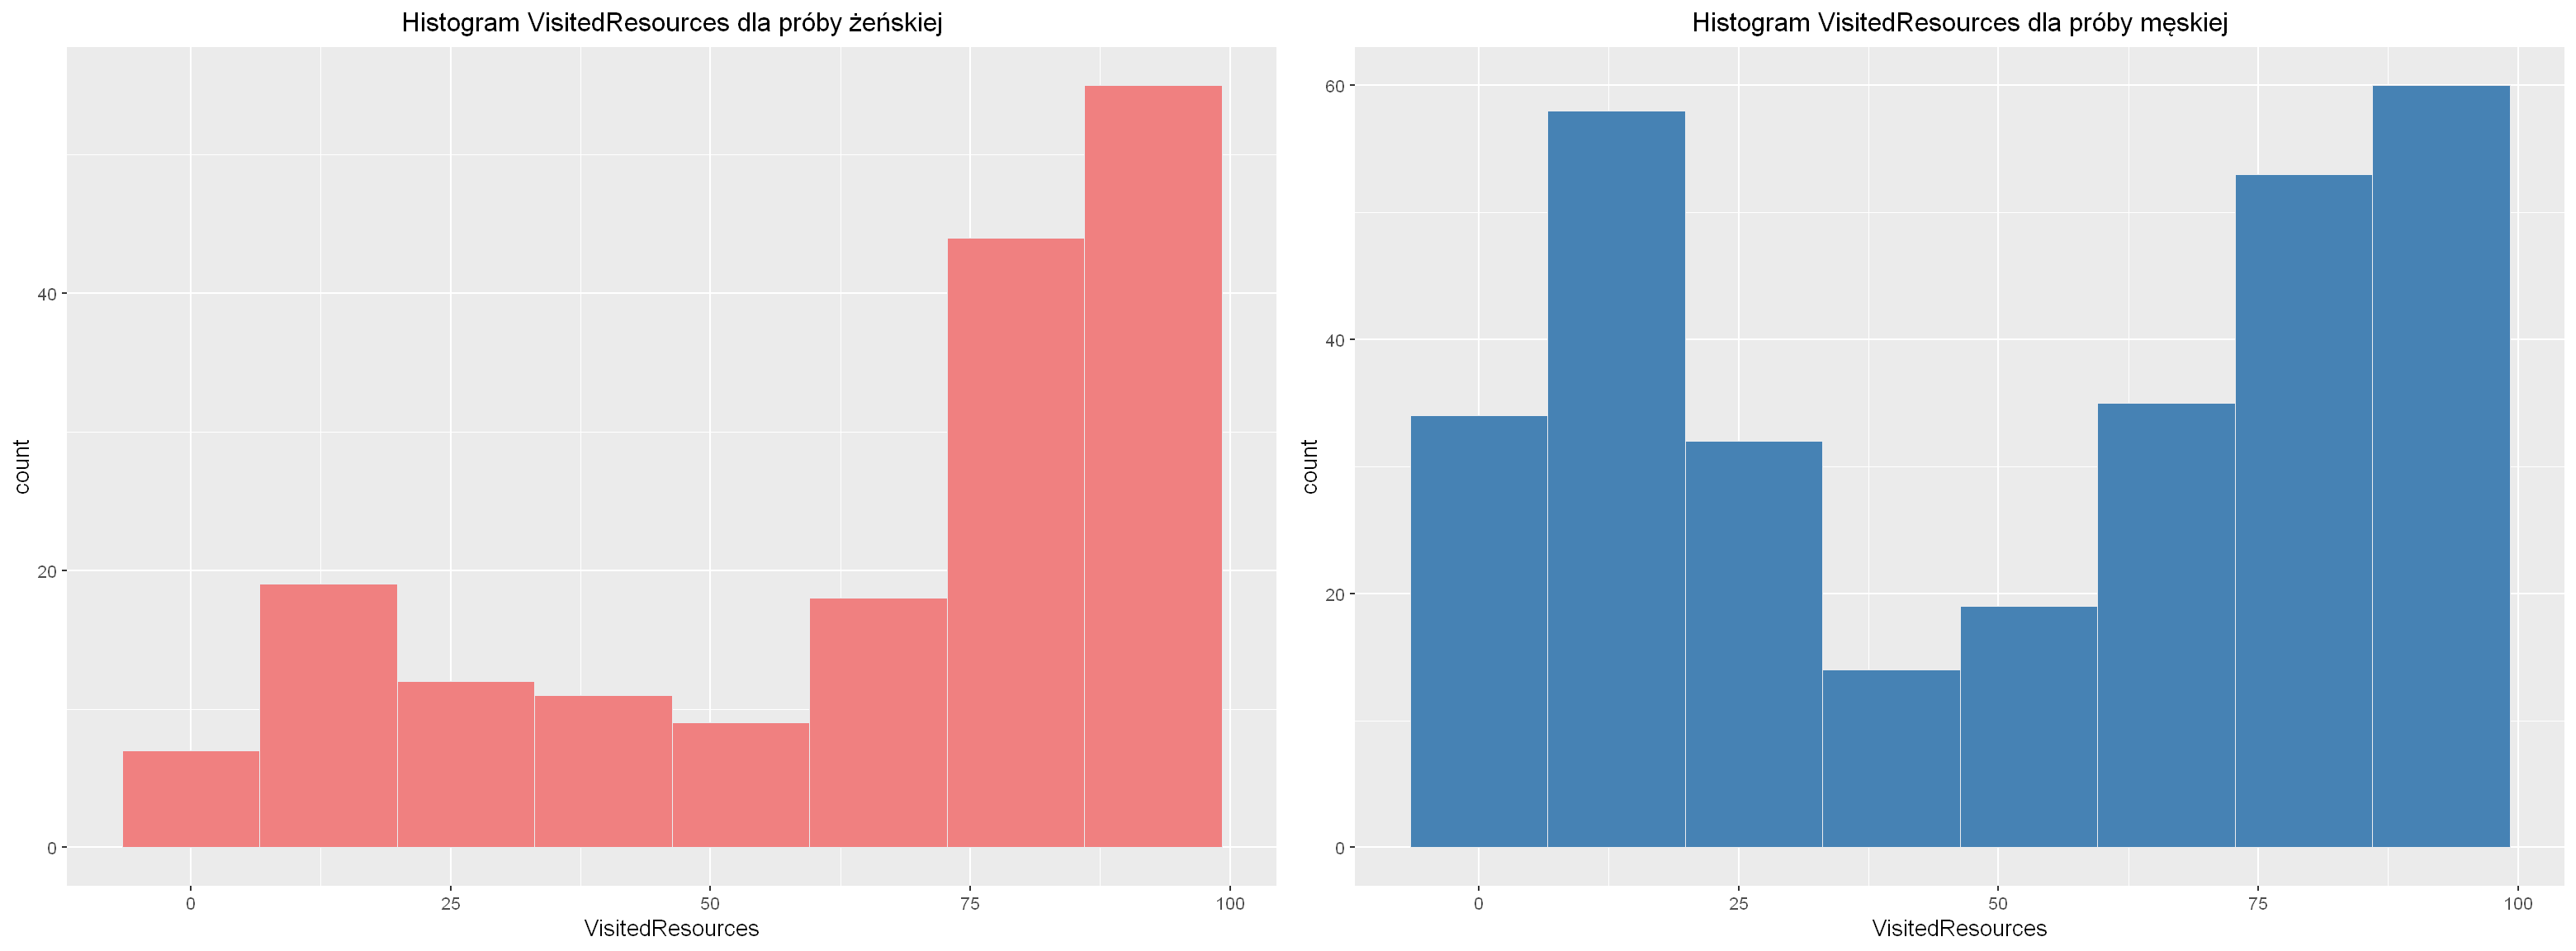

In [17]:
#Tworzymy dwie osobne próbki dla populacji uczniów dziewczyn i uczniów chłopców:
data_F <- filter(data, Gender == 'F')
data_M <- filter(data, Gender == 'M')

change_opt(1.2*h, 2*w)
p1 <- ggplot(data_F, aes(VisitedResources)) +  geom_histogram( binwidth=sqrt(nrow(data_F)), fill="#F08080", color="#eaecef") 
p1 <- p1 +theme_gray(base_size=16) +  ggtitle("Histogram VisitedResources dla próby żeńskiej") + center_title 

p2 <- ggplot(data_M, aes(VisitedResources)) +  geom_histogram( binwidth=sqrt(nrow(data_F)), fill="#4682B4", color="#eaecef") 
p2 <- p2 +theme_gray(base_size=16) +  ggtitle("Histogram VisitedResources dla próby męskiej") + center_title 

grid.arrange(p1, p2, ncol=2)
ladna_tabelka <- data.frame(Gender= c("F", "M"), Skewness = c(skewness(data_F$VisitedResources), skewness(data_M$VisitedResources)))
print(ladna_tabelka)
undo_opt()

##### Spostrzeżenia i wnioski
+ W próbie jednostek płci żeńskiej rozkład cechy jest dość silnie lewoskośny, co potwierdza zarówno analiza graficzna, jak i wyliczony współczynnik asymetrii. 
+ W próbie jednostek płci męskiej kształt rozkład jest bimodalny typu "U". 
+ Wykonanie testu statystycznego wymaga więc dodatkowego sprawdzenia, czy rozkład średniej można przybliżyć rozkładem normalnym, ponieważ przy asymetrycznych rozkładach cechy próba $n>100$ może być niewystarczająca aby zadziałało Centralne Twierdzenie Graniczne.

Zacznijmy od wyliczenia odpowiednich statystyk:

In [18]:
#Liczymy średnią testowanej cechy:
F_vr <- mean(data_F$VisitedResources)
M_vr <- mean(data_M$VisitedResources)

#Odchylenie standardowe:
F_sd <- sd(data_F$VisitedResources)
M_sd <- sd(data_M$VisitedResources)

#Liczność próbek:
n_F <- nrow(data_F)
n_M <- nrow(data_M)

vr <- data.frame(Gender = c("F", "M"), Mean = c(F_vr, M_vr), Sd = c(F_sd, M_sd), N=  c(n_F, n_M))

vr

#Różnica między wartościami średnimi badanej cechy:
F_vr-M_vr


Gender,Mean,Sd,N
<chr>,<dbl>,<dbl>,<int>
F,64.00000,30.20980,175
M,49.51803,33.54318,305


[1] 14.48197

##### Spostrzeżenia i wnisoki
Różnica w średniej ilości odwiedzanych zasobów to około **14.48**. Czy na podstawie wyników otrzymanych dla tej próbki danych możemy wnioskować, że uczniowie płci żeńskiej częściej korzystają z materiałów edukacyjnych? Aby to sprawdzić możemy wykonać test T, ponieważ odchylenia standardowe dla próbek z obu populacji są podobne. Sprawdźmy najpierw założenia:

### 1. Niezależność populacji
Zbiór został stworzony na podstawie danych na temat niezależnych jednostek- uczniów korzystających z LMS, dodatkowo będących na różnych poziomiach edukacji, w różnych sekcjach itp. Obie próbki są niezależne.

### 2. Rozkład normalny wartości średnich

**Dla populacji dziewczyn:**

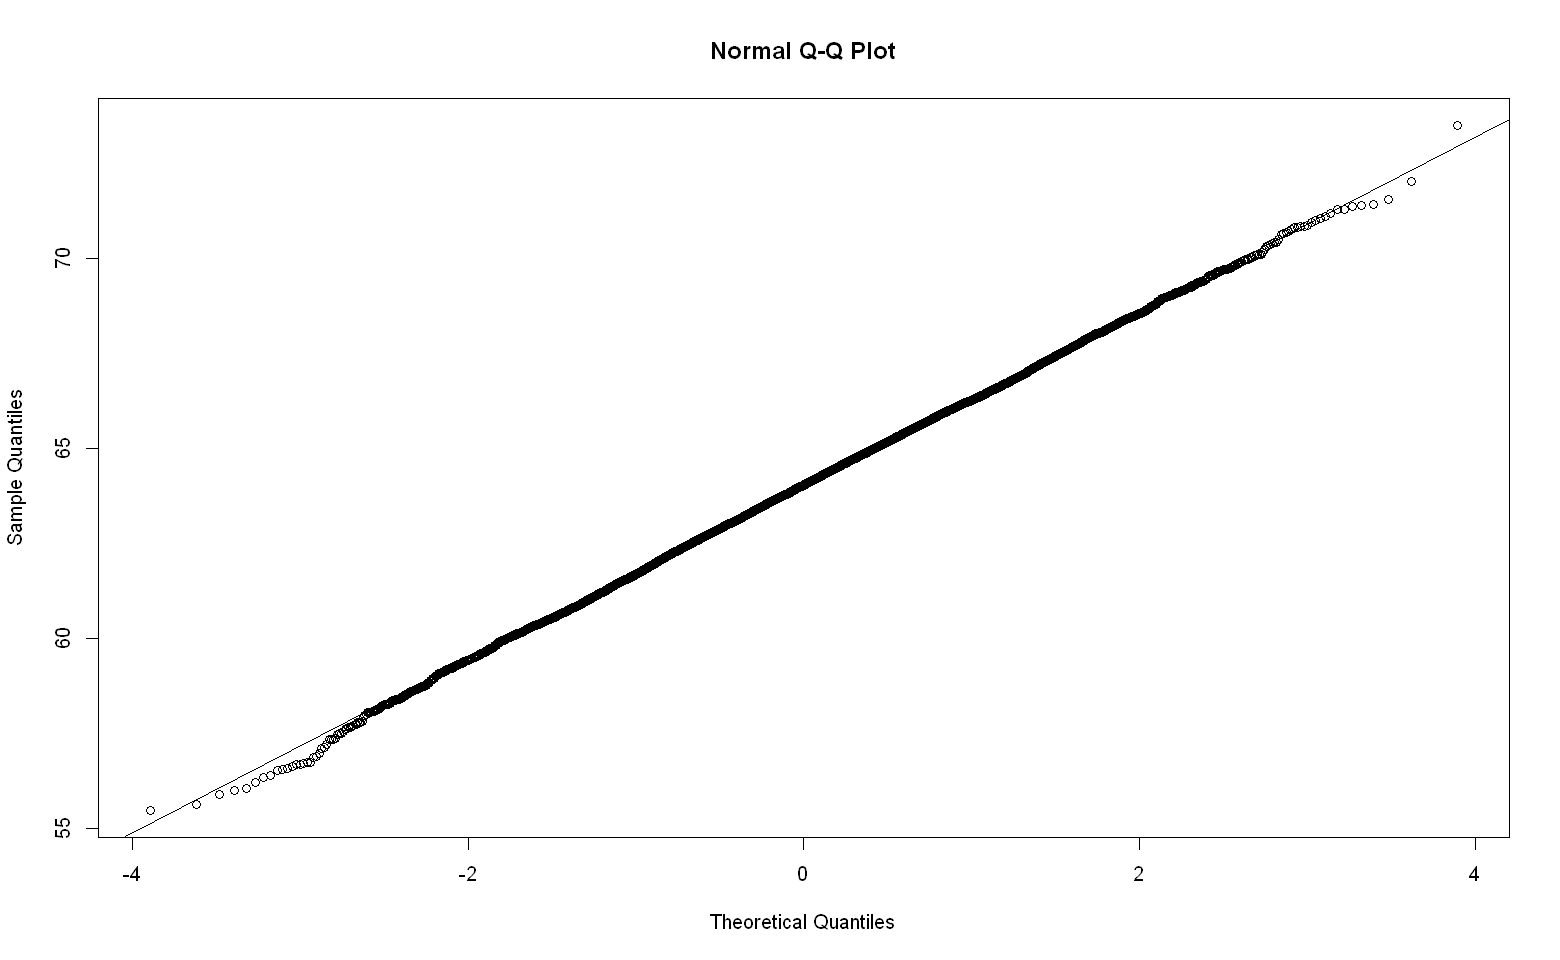

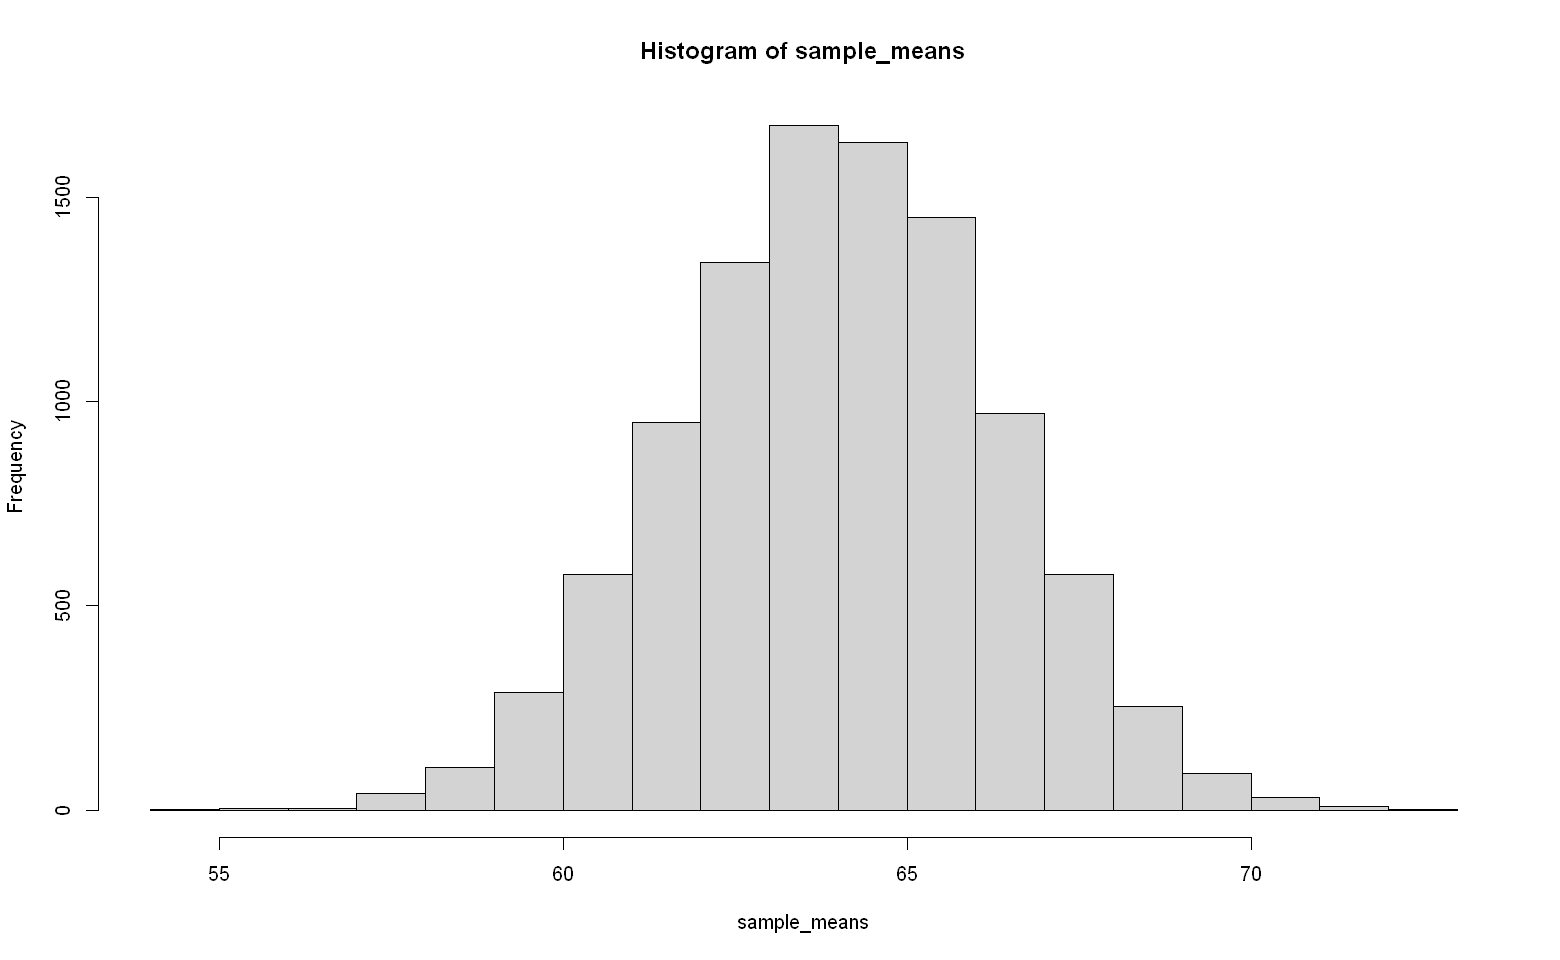

In [19]:
qq_mean(data_F$VisitedResources, n=n_F)
hist_mean(data_F$VisitedResources, n=n_F)

**Dla populacji chłopców:**

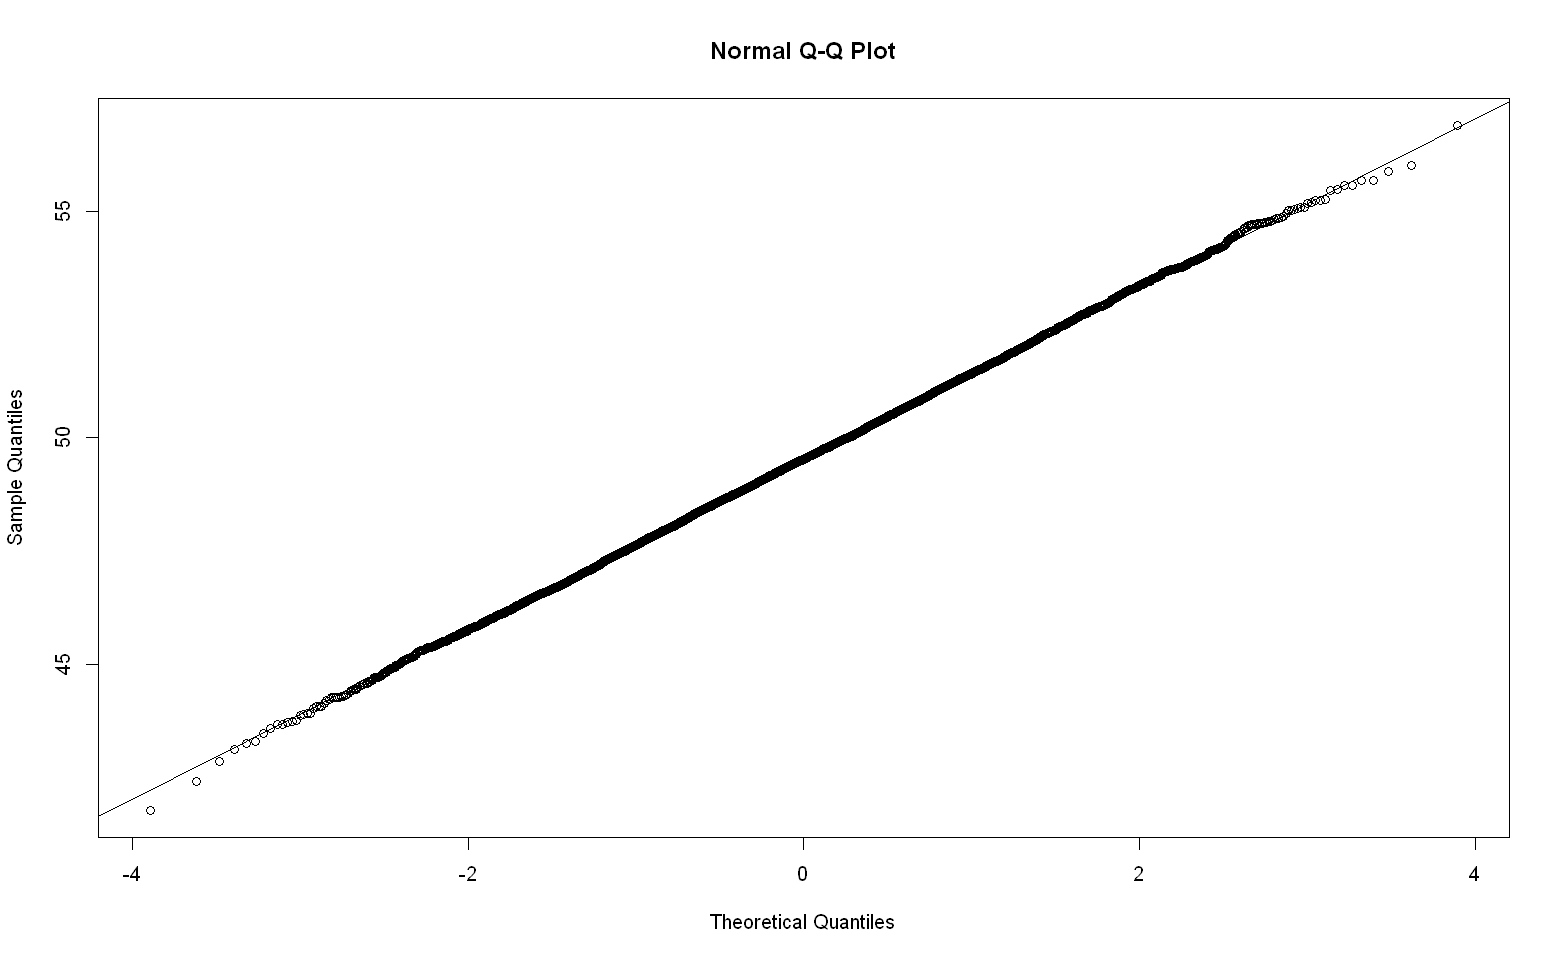

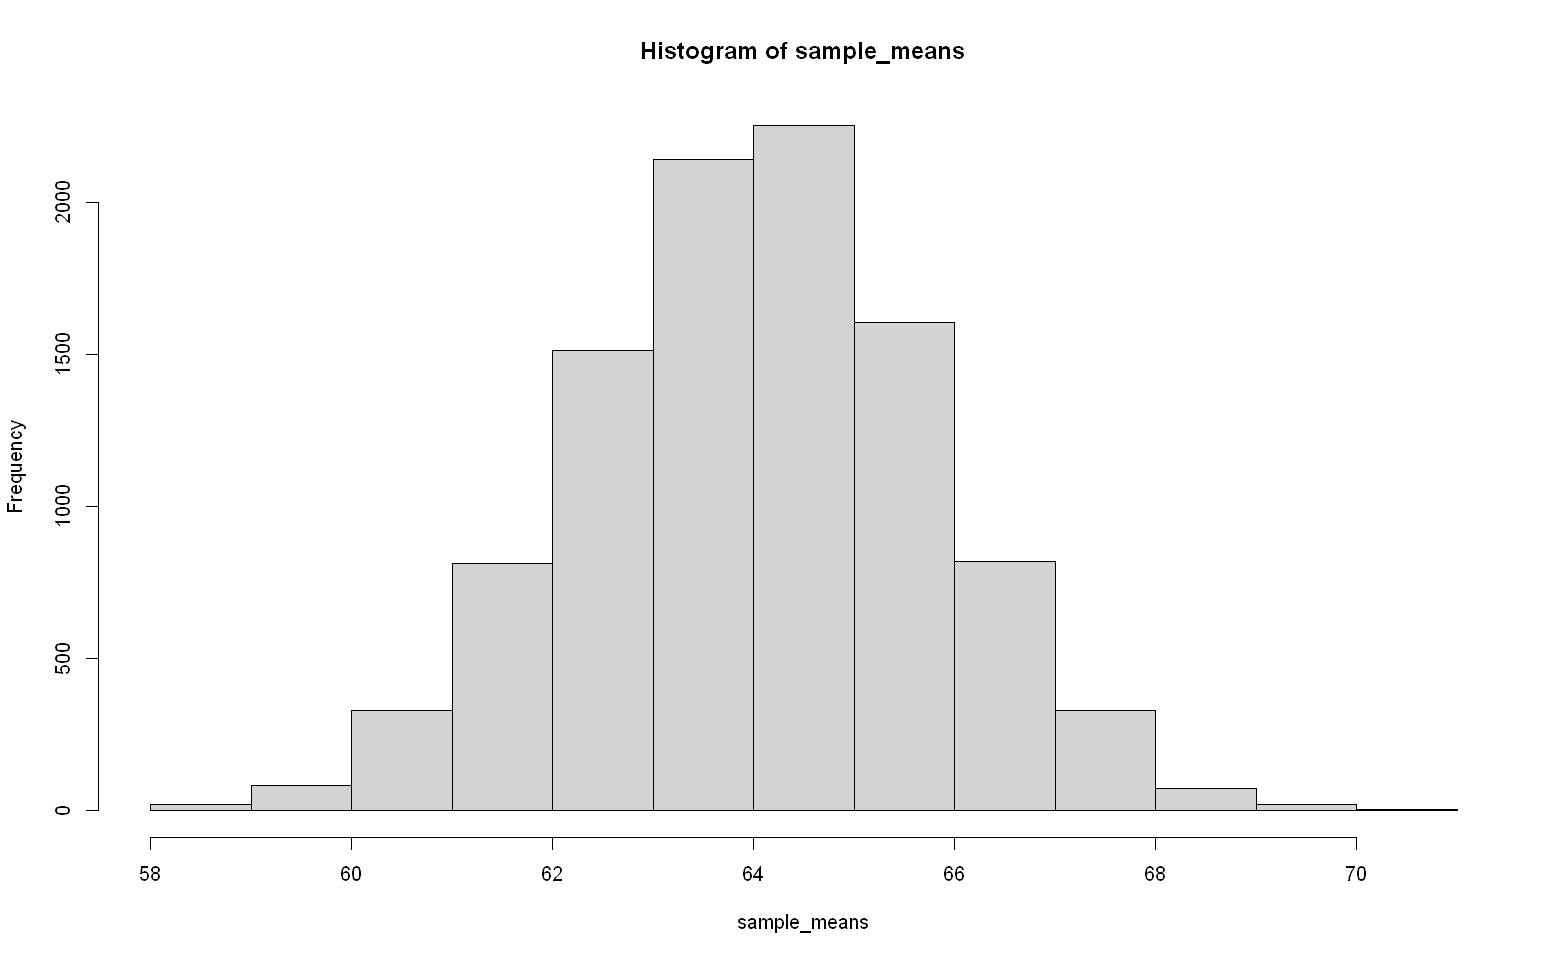

In [21]:
qq_mean(data_M$VisitedResources, n=n_M)
hist_mean(data_F$VisitedResources, n=n_M)

##### Wnioski
Zarówno w przypadku dziewczyn, jak i chłopców rozkład średniej przy wielkości naszych próbek możemy przybliżyć rozkładem normalnym.

### 3. Równość wariancji w populacjach
##### Test F
+ $H_0: \sigma_M^2=\sigma_F^2$
+ $H_1: \sigma_M^2 > \sigma_F^2$
+ $\alpha=5\%$
+ Statystyka testowa $F= \frac{S_M^2}{S_F^2}$

In [27]:
#Statystyka testowa: 
F_t <- M_sd^2/F_sd^2
#P-wartość: P(F>F_t)
p<-pf(F, df1=n_M-1, df2=n_F-1, lower.tail=FALSE) 
p<0.05

[1] FALSE

##### Wnioski
Nie ma podstaw do odrzucenia $H_0$, więc założenie o równości wariancji możemy uznać za zasadne.

### Test T dla dwóch populacji
+ Test dotyczy średniej liczby odwiedzin stron z materiałami edukacyjnymi
+ Populacje:
    + $F$ - dziewczyny uczęszczające do szkół, w której udostępnianie są materiały edukacyjne
    + $M$ - analogiczna definicja dla chłopców
    
+ Poziom istotności testu $\alpha = 5%$
+ Hipoteza zerowa: $H_0: \mu_F \leq \mu_M$
+ Hipoteza alternatywna $H_1: \mu_F > \mu_M$
+ Statystyka $T_{n_f+n_m-2} = \frac
{(\bar{x_F}-\bar{x_M})-0}
{\sqrt
{\frac
{(n_f-1)S_F^2+(n_m-1)S_M^2}{n_f+n_m-2}(\frac{1}{n_f}+\frac{1}{n_m}})}$

In [28]:
wariancja_laczna <- sqrt((((n_F-1)*F_sd^2 + (n_M-1)*M_sd^2)/(n_F+n_M-2))*(1/n_F+1/n_M))
T <- (F_vr-M_vr)/wariancja_laczna
p <- pt(-T, df=n_F+n_M-2) 

p < 0.05 #Test jednostronny
2*p < 0.05 #Test dwustronny

[1] TRUE

[1] TRUE

+ Decyzja: Odrzucamy $H_0$ na rzecz $H_1$ z prawdopodobieństem popełnienia błędu I-rodzaju równym $5\%$. Dodatkowo, pokazaliśmy, że test dwustronny miałby taki sam rezultat.

#### Wnioski
Powyższy test statystyczny pokazał na podstawie tej próbki danych, że wśród młodzieży szkolnej jednostki płci żeńskiej średnio więcej korzystają z materiałów edukacyjnych. Cecha tego typu może być interpretowana jako pewna miara zaangażowania w proces nauki razem z innymi funkcjami behawioralnymi: `RaisedHand`, `DiscussionGroups` i `AnnouncementsViews`. Idąc tym tropem, możemy sprawdzić, czy podobna różnica pomiędzy płciami dotyczy też tych innych cech. 

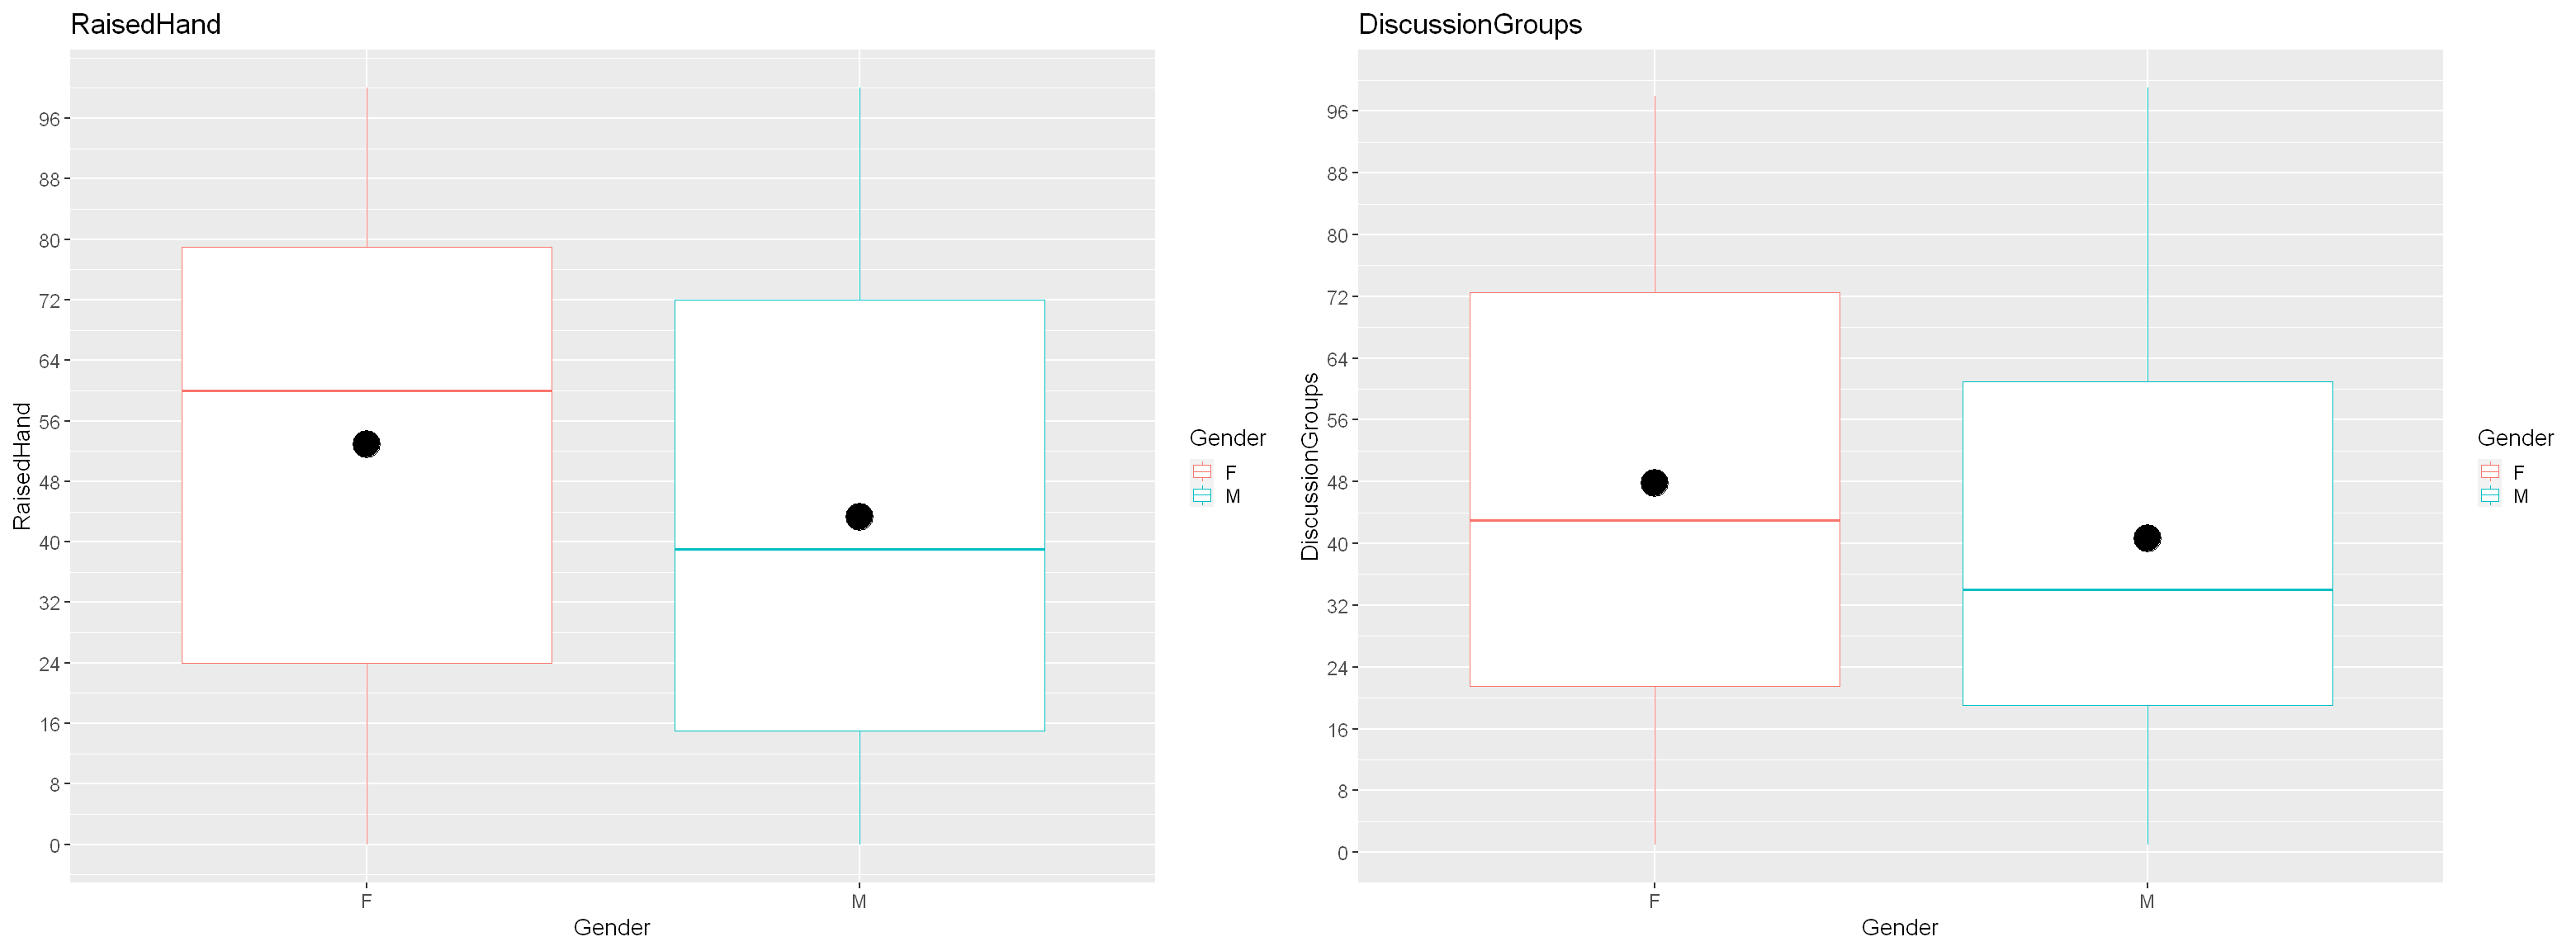

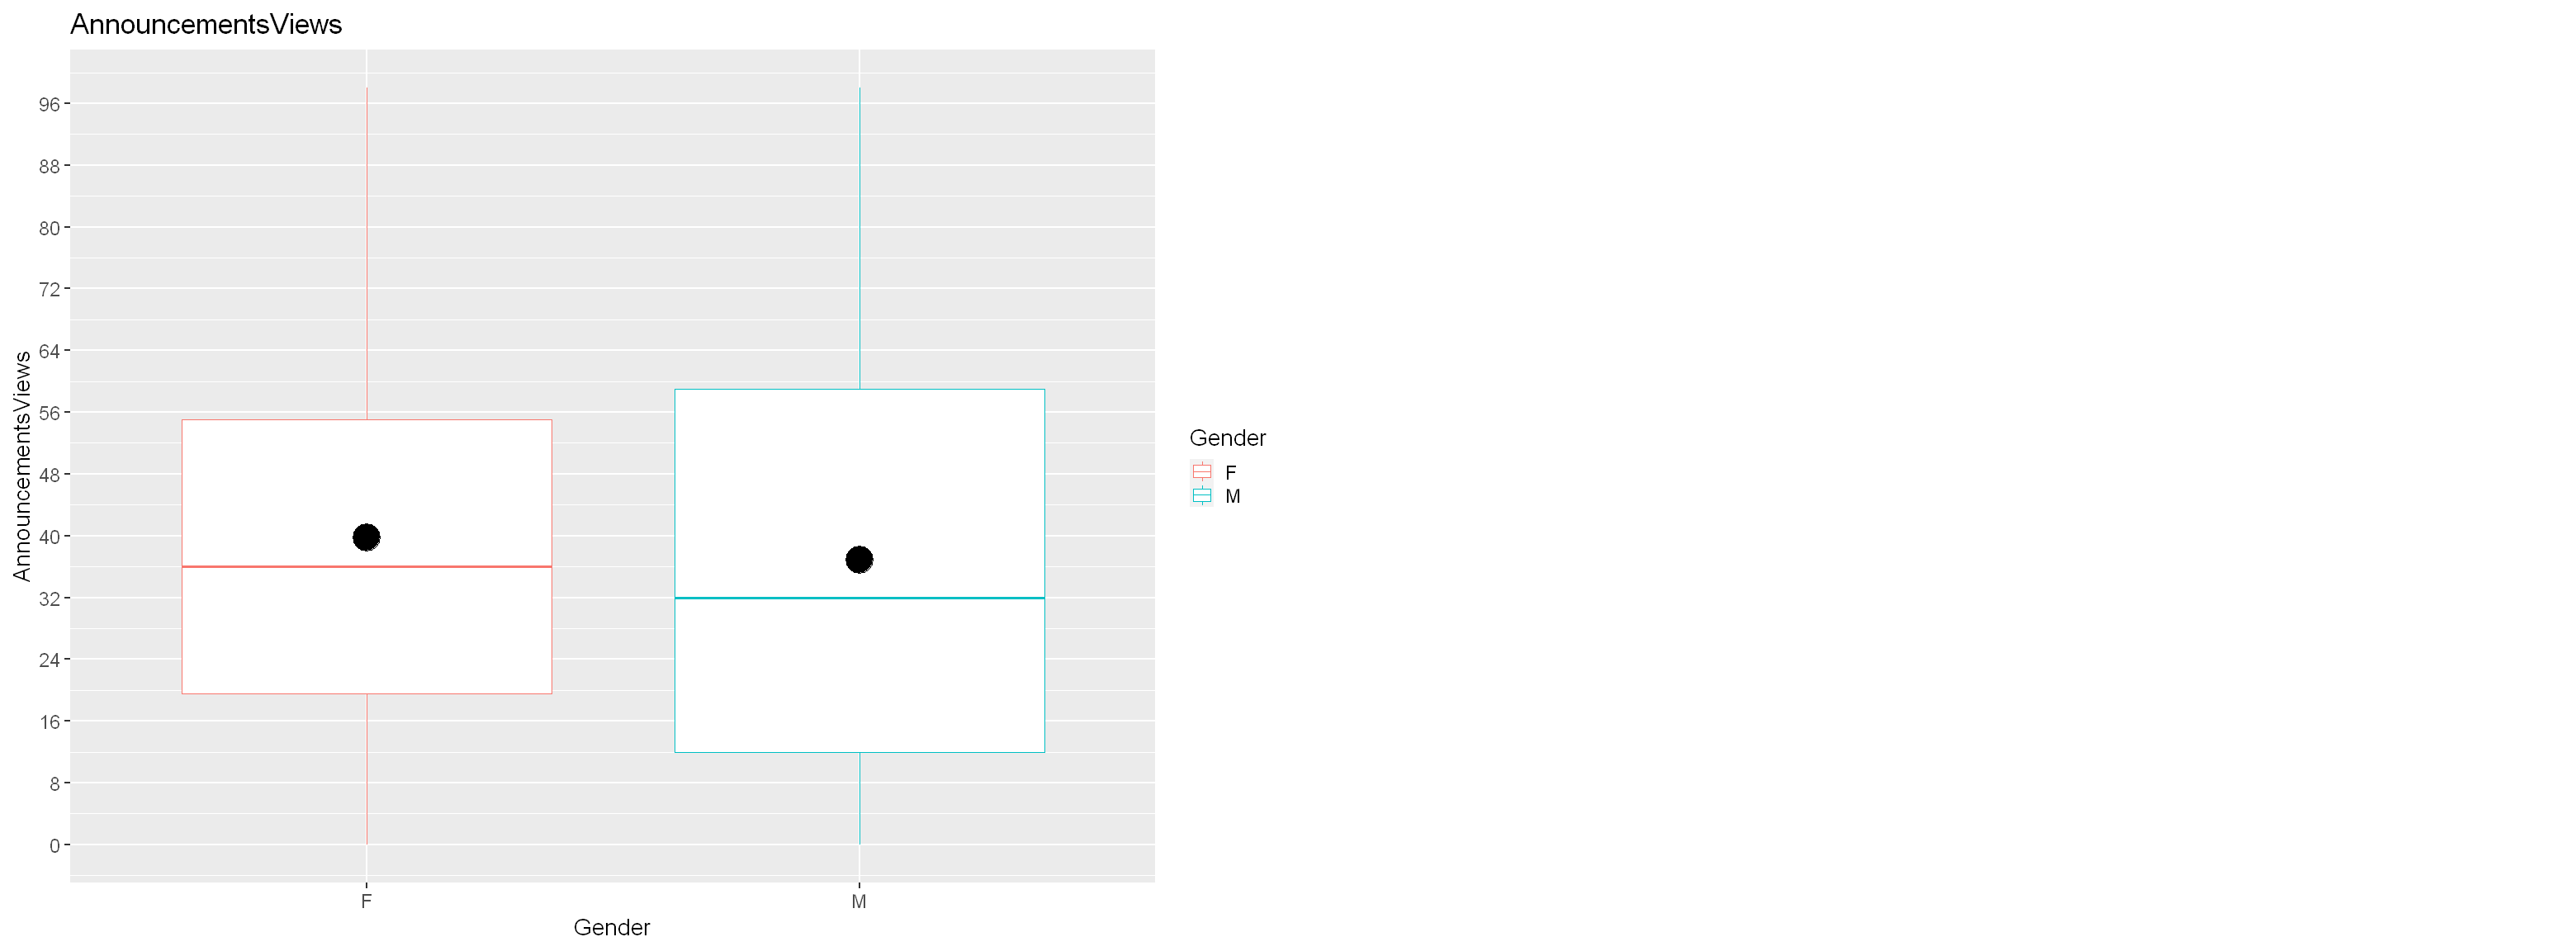

In [29]:
p1 <- ggplot(data, aes(x=Gender, y=RaisedHand, color=Gender)) + ggtitle("RaisedHand") + 
  geom_boxplot(outlier.size=4)  + scale_y_continuous(breaks = seq(0,100,8)) +theme_gray(base_size=17) + stat_summary(fun=mean, geom="point", shape=20, size=14, color="black", fill="black")

p2 <- ggplot(data, aes(x=Gender, y=DiscussionGroups, color=Gender)) + ggtitle("DiscussionGroups") +
  geom_boxplot(outlier.size=4)  + scale_y_continuous(breaks = seq(0,100,8)) +theme_gray(base_size=17) + stat_summary(fun=mean, geom="point", shape=20, size=14, color="black", fill="black")

p3 <- ggplot(data, aes(x=Gender, y=AnnouncementsViews, color=Gender))  +
  geom_boxplot(outlier.size=4)  +  ggtitle("AnnouncementsViews") + scale_y_continuous(breaks = seq(0,100,8)) +theme_gray(base_size=17) + stat_summary(fun=mean, geom="point", shape=20, size=14, color="black", fill="black")

change_opt(1.2 * h, 2*w)
grid.arrange(p1, p2, ncol=2)
grid.arrange(p3, ncol=2)
undo_opt()

##### Spostrzeżenia i wnioski
+ Rzeczywiście dla innych cech tego typu średnia wśród uczniów płci żeńskiej jest wyższa, jednak dla cechy `AnnouncementsViews` jest ona bardzo niewielka.
+ Skoro dla próbki żeńskiej analizowane cechy mają średnio wyższą wartość, to możemy podejrzewać, że są one skorelowane. Sprawdźmy to przez policzenie wskaźnika korelacji Pearsona i jego kwadratu dla wszystich par tych zmiennych:

In [30]:
d <- data.frame(data$VisitedResources, data$AnnouncementsView, data$RaisedHand, data$DiscussionGroups, as.numeric(data$GradeClass))

k <- cor(d)
k
k^2

,data.VisitedResources,data.AnnouncementsView,data.RaisedHand,data.DiscussionGroups,as.numeric.data.GradeClass.
data.VisitedResources,1.0000000,0.5945000,0.6915717,0.2432918,0.6770936
data.AnnouncementsView,0.5945000,1.0000000,0.6439178,0.4172900,0.5273700
data.RaisedHand,0.6915717,0.6439178,1.0000000,0.3393860,0.6462984
data.DiscussionGroups,0.2432918,0.4172900,0.3393860,1.0000000,0.3081826
as.numeric.data.GradeClass.,0.6770936,0.5273700,0.6462984,0.3081826,1.0000000


,data.VisitedResources,data.AnnouncementsView,data.RaisedHand,data.DiscussionGroups,as.numeric.data.GradeClass.
data.VisitedResources,1.00000000,0.3534303,0.4782714,0.05919088,0.45845571
data.AnnouncementsView,0.35343028,1.0000000,0.4146301,0.17413094,0.27811916
data.RaisedHand,0.47827142,0.4146301,1.0000000,0.11518285,0.41770168
data.DiscussionGroups,0.05919088,0.1741309,0.1151829,1.00000000,0.09497649
as.numeric.data.GradeClass.,0.45845571,0.2781192,0.4177017,0.09497649,1.00000000


##### Spostrzeżenia i wnioski
+ Dla wszystkich par cech współczynnik korelacji Pearsona jest dodatni.
+ Cechą najsłabiej skorelowaną liniowo z pozostałymi cechami jest `DiscussionGroups`, a c najważniejsze wydaje się, że zmienna ta jest bardzo słabo skorelowana liniowo z osiąganą przez uczniów oceną ($R^2 \approx 0.09$). 
+ `VisitedResources` jest silnie skorelowane z liczbą podniesień ręki `RaisedHand` ($R^2 \approx 0.48$) i z osiąganą przez ucznia oceną ($R^2 \approx 0.46$). 
+ Liczba wyświetleń ogłoszeń bieżących `AnnouncementsView` jest średnio skorelowana z oceną ($R^2 \approx 0.28$) i silnie skorelowana z `VisitedResources` ($R^2\approx 0.35$) i `RaisedHand` ($R^2\approx0.41$).
+ `RaisedHand` jest silnie skorelowana z `GradeClass` ($R^2 \approx 0.42$).

Sprawdźmy te zależności dodatkowo przez narysowanie wykresów rozrzutu dla badanych cech, szczególnie dla klas ocen, dodając do `GradeClass` niewielki szum, aby zależności były bardziej widoczne.  W tym celu cecha `GradeClass` przedstawiona jest numerycznie w poniższy sposób:
+ `L`- 1
+ `M`- 2
+ `H`- 3

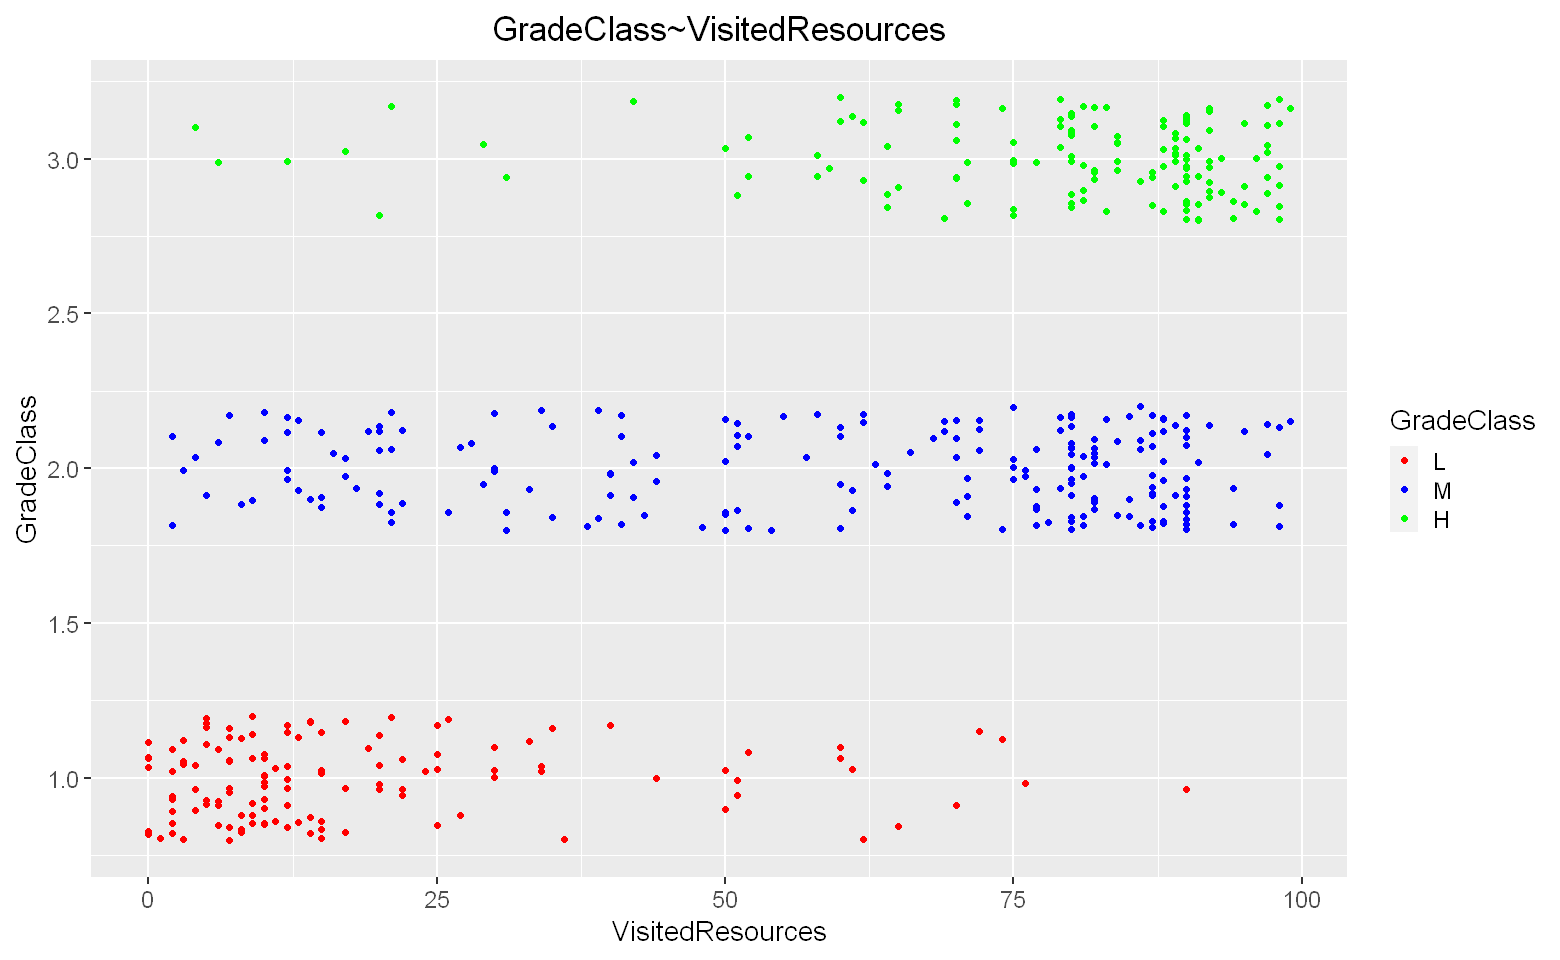

In [31]:
c <-  scale_color_manual(values=c("red", "blue", "green")) 
t <-  theme_gray(base_size=17) 

ggplot(data, aes(y=jitter(as.numeric(GradeClass)), x=VisitedResources, color=GradeClass)) + geom_point() + t + ylab("GradeClass")+c+ggtitle("GradeClass~VisitedResources")+center_title

##### Spostrzeżenia
Wykres rozrzutu pokrywa się z wyliczonym wcześniej współczynnikiem korelacji- można zaobserwować na wykresie pozytywny trend liniowy.

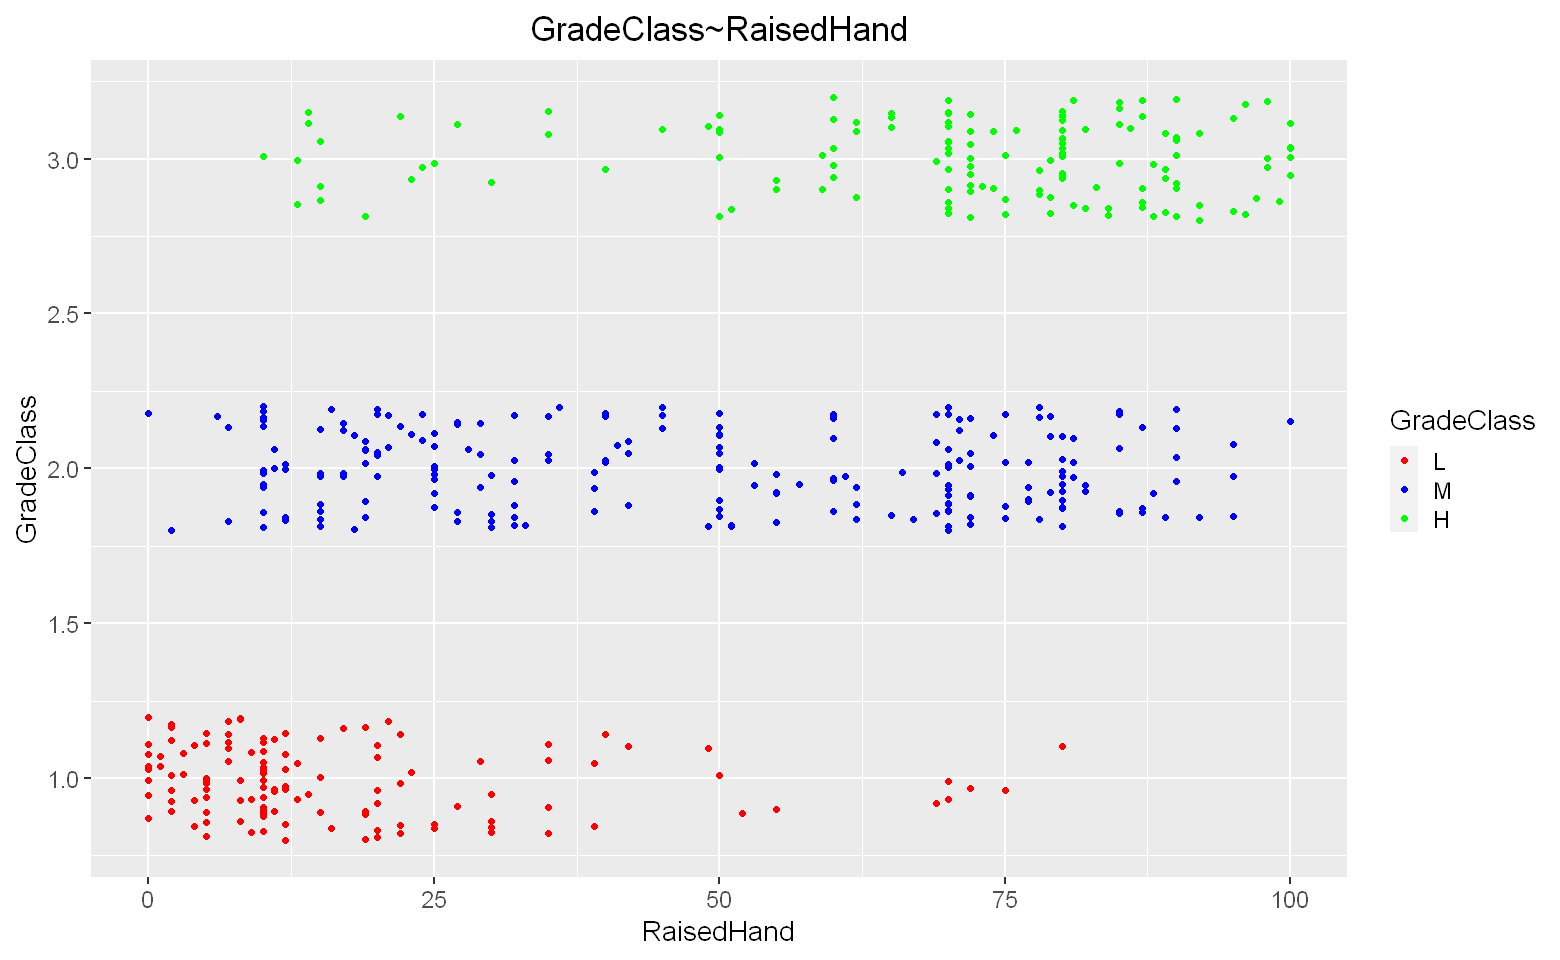

In [32]:
ggplot(data, aes(y=jitter(as.numeric(GradeClass)), x=RaisedHand, color=GradeClass)) + geom_point() + t + ylab("GradeClass") +c+ggtitle("GradeClass~RaisedHand")+center_title

##### Spostrzeżenia
Wykres rozrzutu pokrywa się z wyliczonym wcześniej współczynnikiem korelacji- można zaobserwować na wykresie pozytywny trend liniowy.

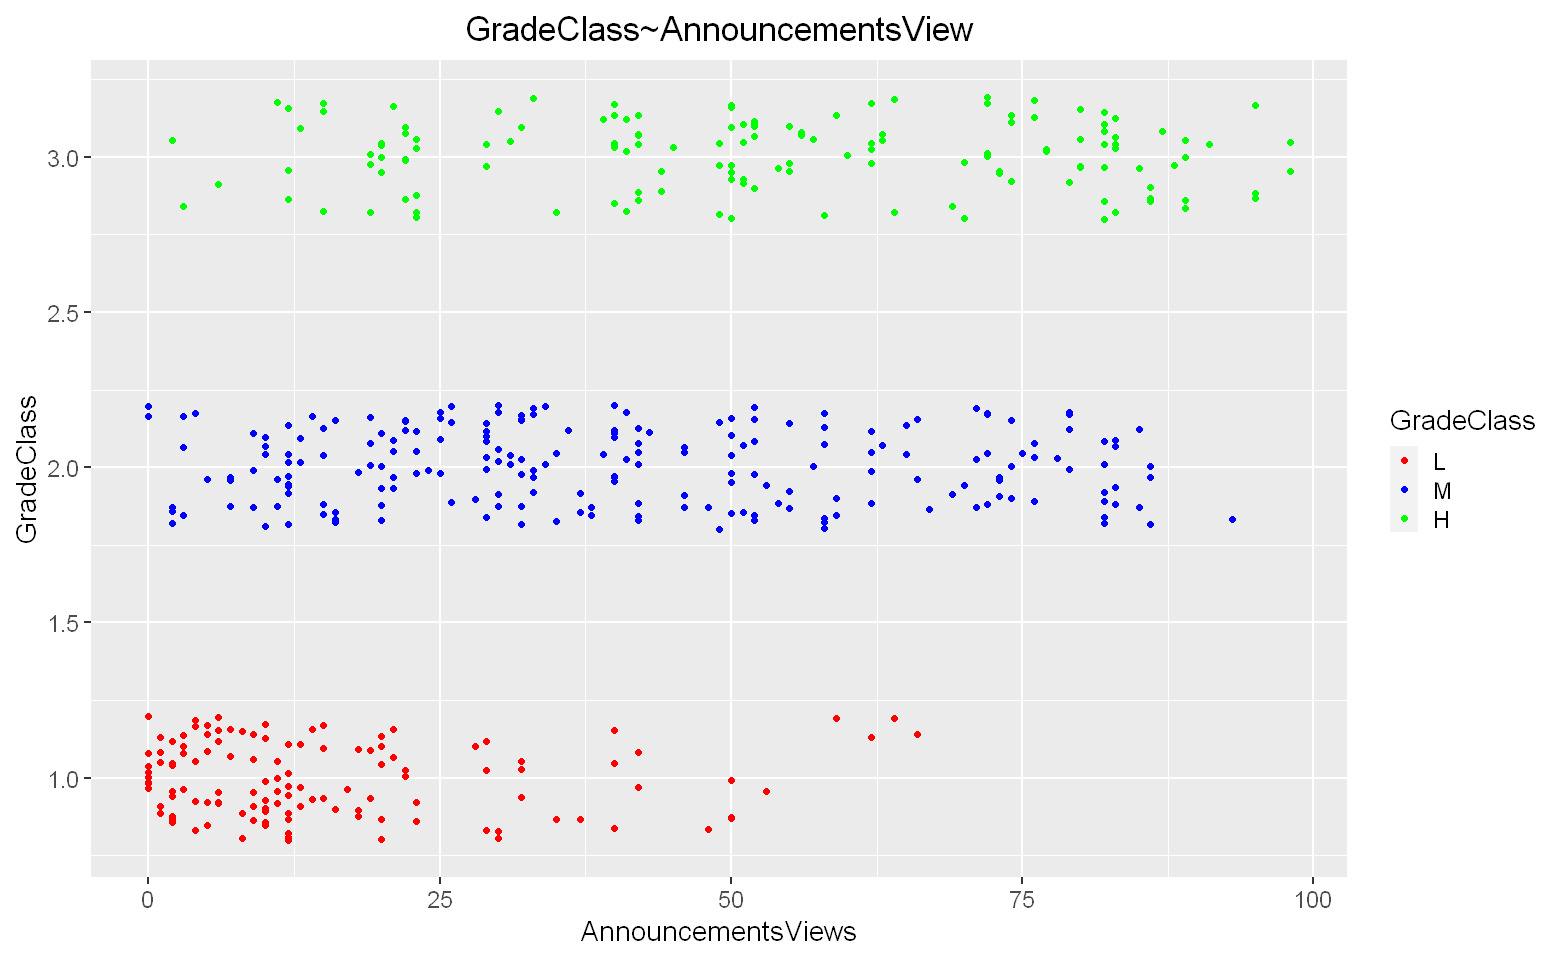

In [33]:
ggplot(data, aes(y=jitter(as.numeric(GradeClass)), x=AnnouncementsViews, color=GradeClass)) + geom_point() + t + ylab("GradeClass") +c+ggtitle("GradeClass~AnnouncementsView")+center_title 

##### Spostrzeżenia
Wykres rozrzutu pokrywa się z wyliczonym wcześniej współczynnikiem korelacji- można zaobserwować na wykresie pozytywny trend liniowy.

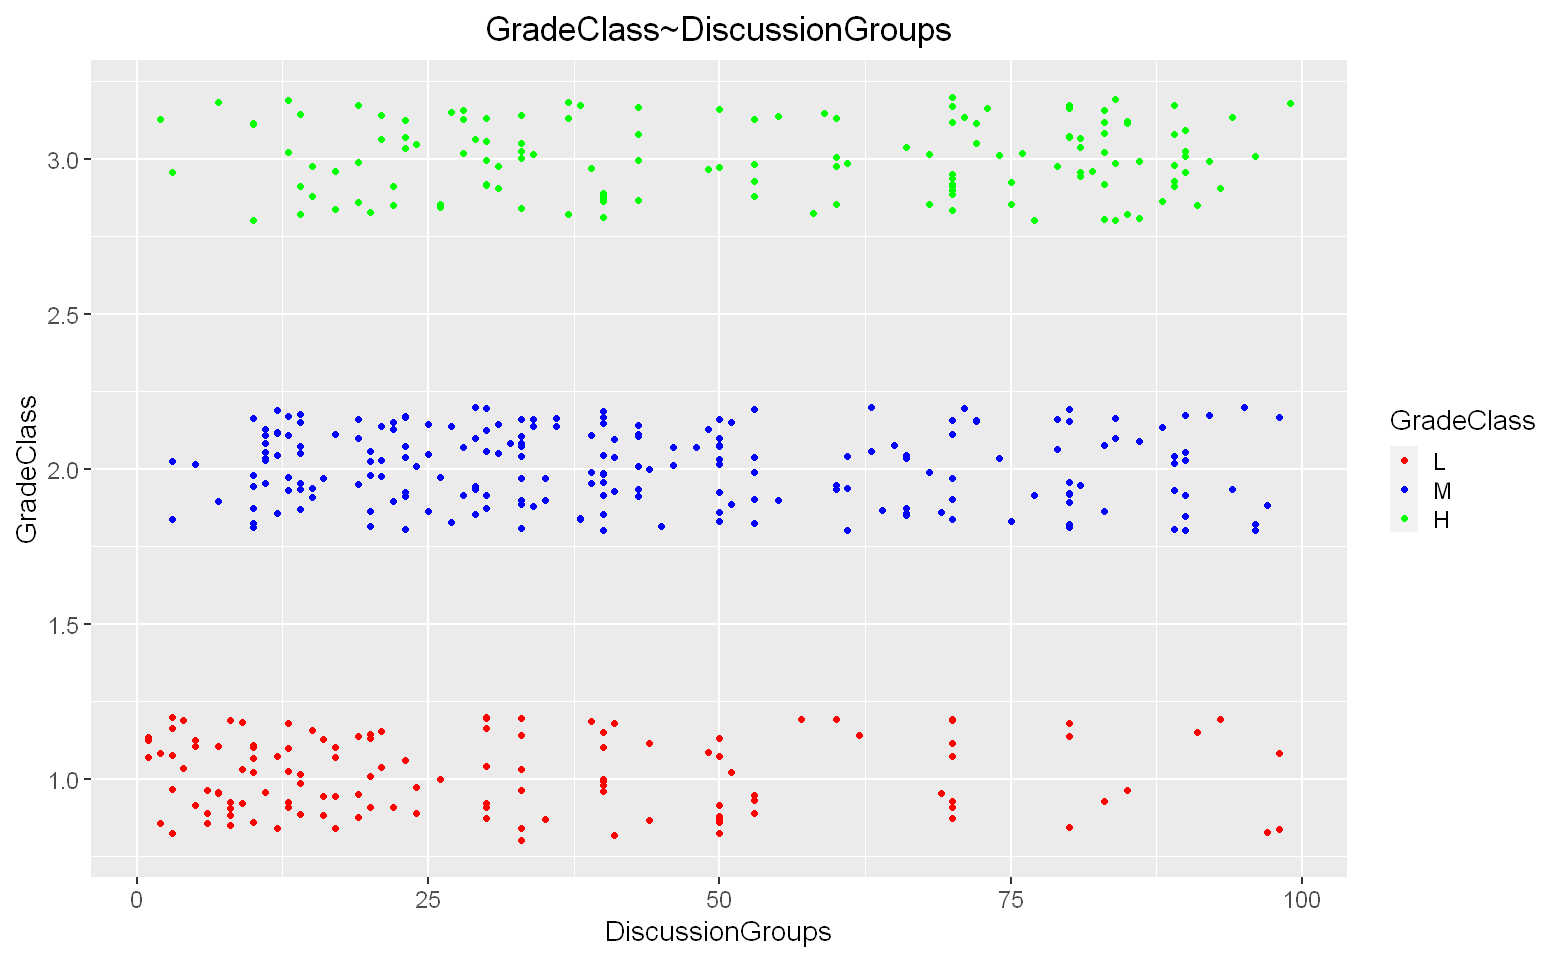

In [34]:
ggplot(data, aes(y=jitter(as.numeric(GradeClass)), x=DiscussionGroups, color=GradeClass)) + geom_point() + t + ylab("GradeClass") +c+ggtitle("GradeClass~DiscussionGroups")+center_title 

##### Spostrzeżenia
Wykres rozrzutu pokrywa się z wyliczonym wcześniej współczynnikiem korelacji- na wykresie nie zauważamy trendu liniowego, a jedynie większą gęstość ocen w klasie niskiej dla mniejszych wartości `DiscussionGroups`.

#### Wnioski
+ Graficzna analiza potwierdza analizę obliczeniową- między zmienną `GradeClass` a `RaisedHand`, `VisitedResources` i `AnnouncementsView` występuję silna pozytywna korelacja liniowa. Natomiast dla `DiscussionGroups` i `GradeClass` nie zauważamy trendu liniowego. 

Sprawdźmy te wnioski dodatkowo, przeprowadzając masowy test T na korelację:

#### Test T dla współczynnika korelacji
+ Próba losowa prosta.
+ $n$ jest dla wszystkich testowanych współczynników takie samo i wynosi $447$
+ Istotność testu: $\alpha = 5%$
+ Hipoteza zerowa: $H_0:\rho = 0$
+ Hipoteza alternatywna: $H_1: \rho \neq 0$
+ Statystyka testowa: $T_{n-2}= \frac{r_{x,y}}{\sqrt{1-r_{x,y}^2}}\sqrt{n-2}$

In [35]:
wart_kryt <- qt(0.975, df=445)
wart_kryt

[1] 1.965309

+ Przedział krytyczny: $(-\infty, -1.965) \cup (1.965, \infty)$

In [36]:
#Najpierw tworzymy tabelę współczynników korelacji Pearsona, które nas interesują:
rs <- data.frame(data$VisitedResources, data$AnnouncementsView, data$RaisedHand, as.numeric(data$GradeClass))
c <- cor(rs)

#Potem masowo możemy obliczyć statystykę testową:
st <- c/sqrt((1-c^2))*sqrt(n-2)

#Statystyki testowe:
st

#Wyniki testu (jeżeli TRUE, to odrzucamy H0 na rzecz H1):
wynik <- st>wart_kryt
wynik

,data.VisitedResources,data.AnnouncementsView,data.RaisedHand,as.numeric.data.GradeClass.
data.VisitedResources,Inf,16.16435,20.93287,20.11619
data.AnnouncementsView,16.16435,Inf,18.40048,13.57052
data.RaisedHand,20.93287,18.40048,Inf,18.51716
as.numeric.data.GradeClass.,20.11619,13.57052,18.51716,Inf


,data.VisitedResources,data.AnnouncementsView,data.RaisedHand,as.numeric.data.GradeClass.
data.VisitedResources,TRUE,TRUE,TRUE,TRUE
data.AnnouncementsView,TRUE,TRUE,TRUE,TRUE
data.RaisedHand,TRUE,TRUE,TRUE,TRUE
as.numeric.data.GradeClass.,TRUE,TRUE,TRUE,TRUE


##### Wnioski
Powyższy test stanowi dodatkowe potwierdzenie, że dla badanych zmiennych $R^2\neq0$.

Wynik wykonanego wcześniej testu T dla `VisitedResources` i powyższa analiza korelacji zmiennych sugerują, że w analizowanej próbce danych dziewczyny powinny osiągać średnio lepsze wyniki w nauce niż chłopcy. Sprawdźmy to przez narysowanie rozkładu płci w poszczególnych klasach ocen:

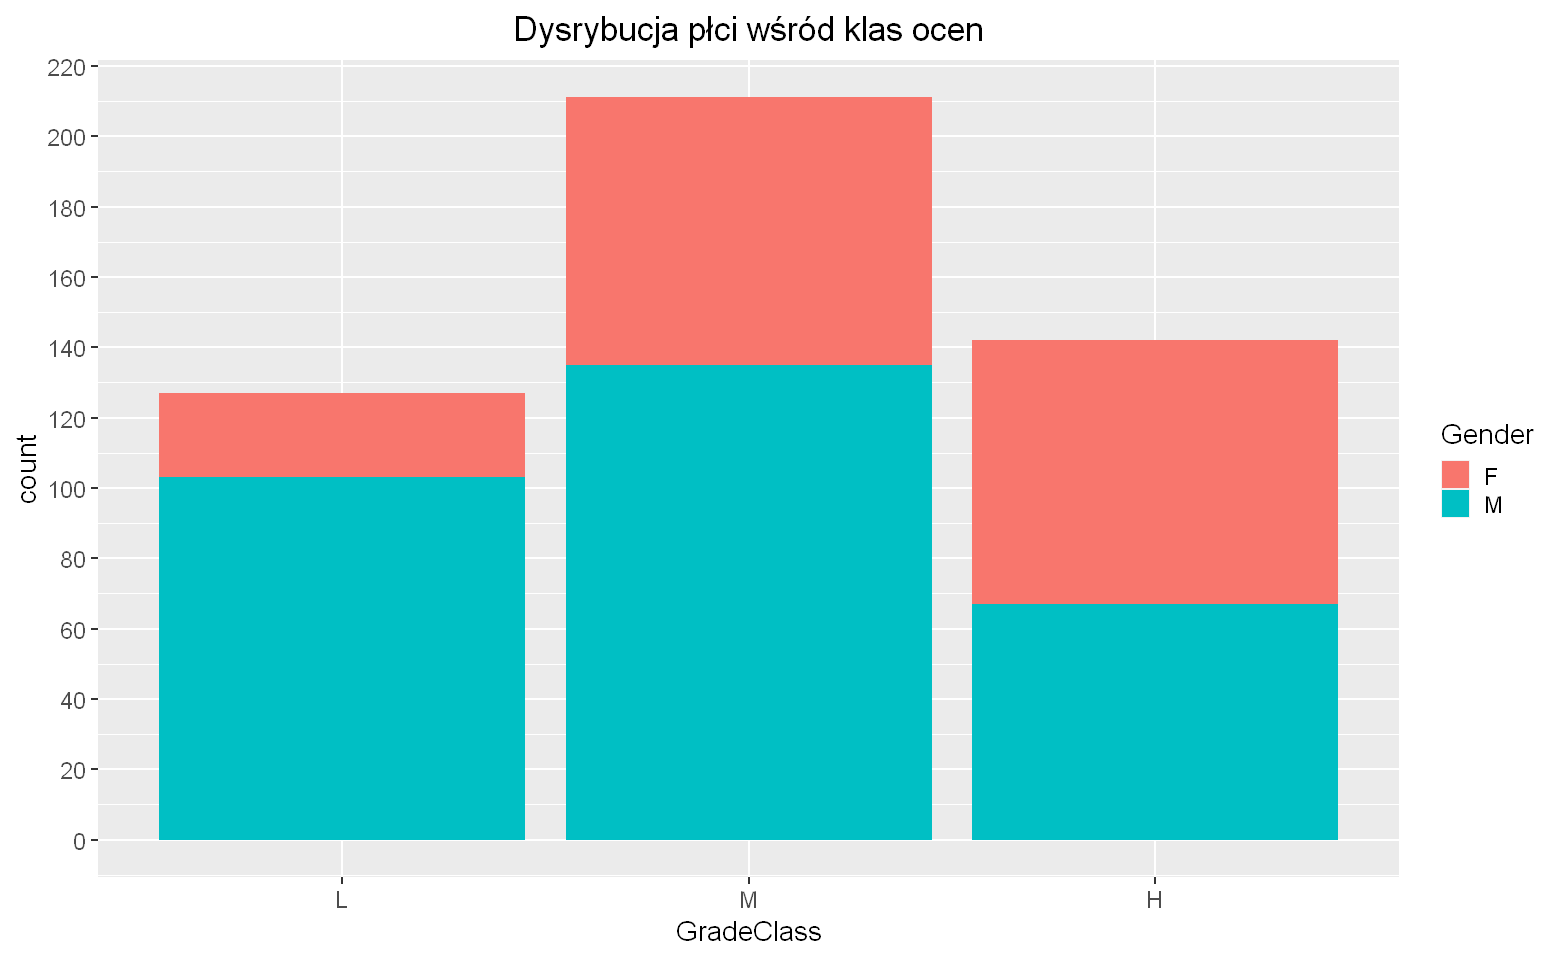

In [37]:
plot<- ggplot(data, aes(x = GradeClass, fill=Gender)) + geom_bar() + theme_gray(base_size=17) + scale_y_continuous(breaks=seq(0,220,20))
plot <- plot + ggtitle("Dysrybucja płci wśród klas ocen") + center_title

plot

##### Spostrzeżenia i wnioski
+ Relatywnie mało dziewczyn osiąga ocenę klasy `Low`, a stosunkowo dużo ocenę klasy `High`. 
+ Wykres potwierdza początkowe spostrzeżenie: według analizowanych danych dziewczyny średnio uczą się lepiej niż chłopcy. 

In [38]:
grade_F <- as.numeric(data_F$GradeClass)
grade_M <- as.numeric(data_M$GradeClass)

#Liczymy średnią testowanej cechy:
F_mean <- mean(grade_F)
M_mean <- mean(grade_M)


#Odchylenie standardowe:
F_sd <- sd(grade_F)
M_sd <- sd(grade_M)

#Liczność próbek:
n_F <- nrow(data_F)
n_M <- nrow(data_M)

g <- data.frame(Gender = c("F", "M"), Mean = c(F_mean, M_mean), Sd = c(F_sd, M_sd), N=  c(n_F, n_M))

g


Gender,Mean,Sd,N
<chr>,<dbl>,<dbl>,<int>
F,2.291429,0.6953753,175
M,1.881967,0.7383989,305


##### Spostrzeżenia i wnioski
+ Z danych wynika, że dziewczyny osiągają średnio wyższą ocenę.
+ Wariancje w obu próbkach są podobne, więc możemy przeprowadzić test T dla dwóch populacji. Próbki są niezależne, co zostało już omówione wcześniej. Musimy więc sprawdzić tylko rozkład średniej dla obu próbek i założenie o równości wariancji:

### 1. Rozkład normalny średniej

**Dla dziewczyn:**

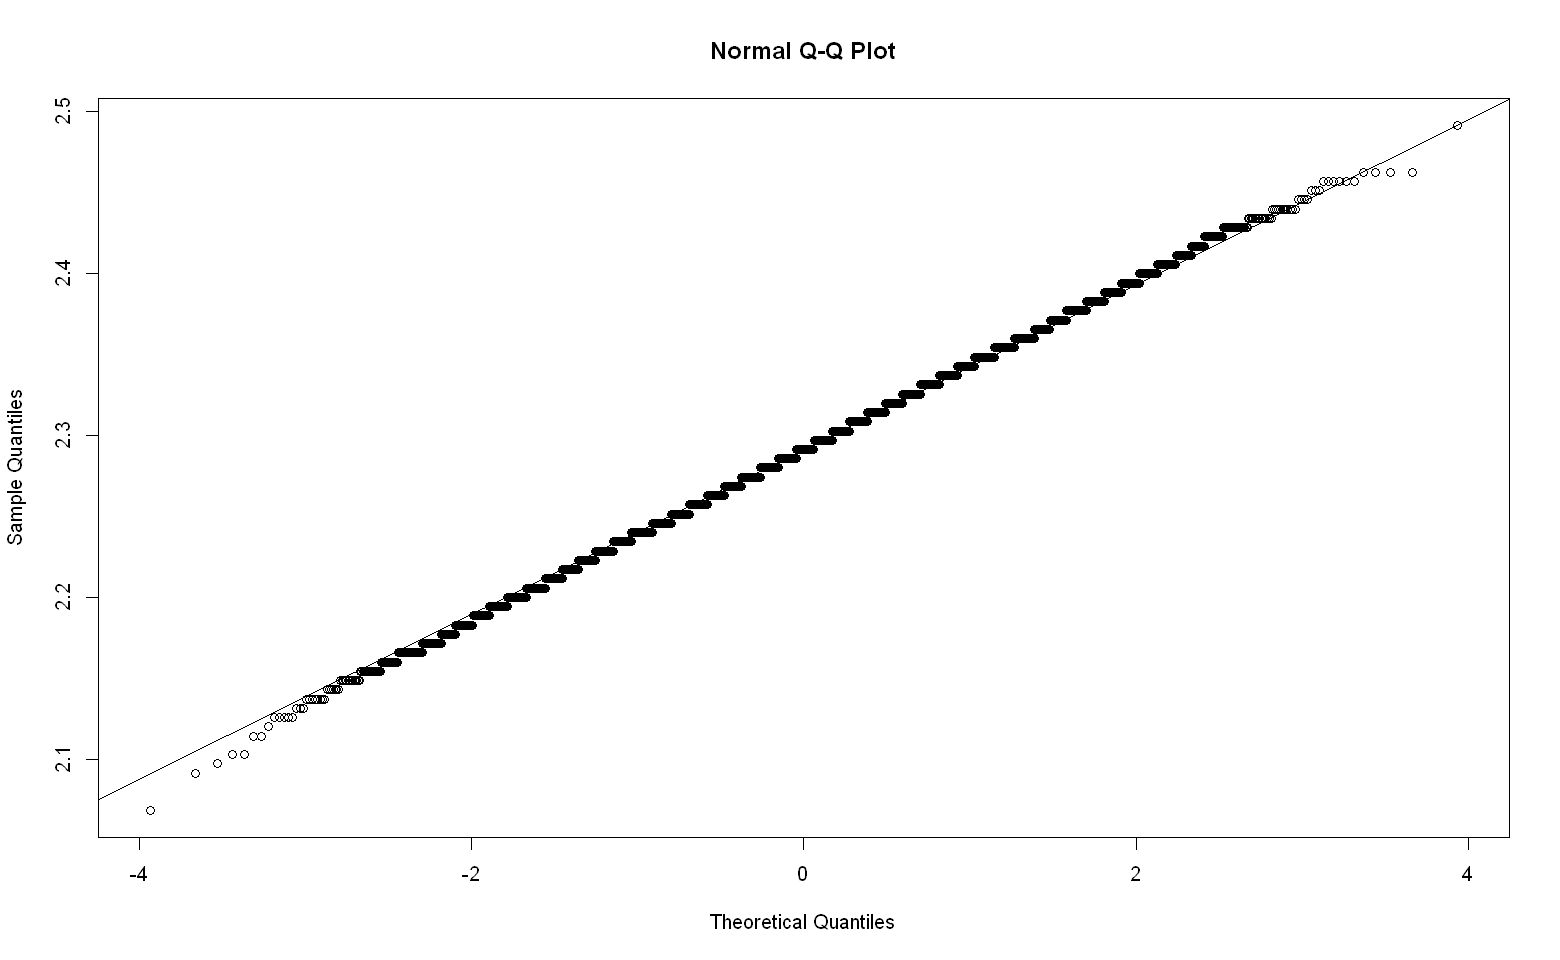

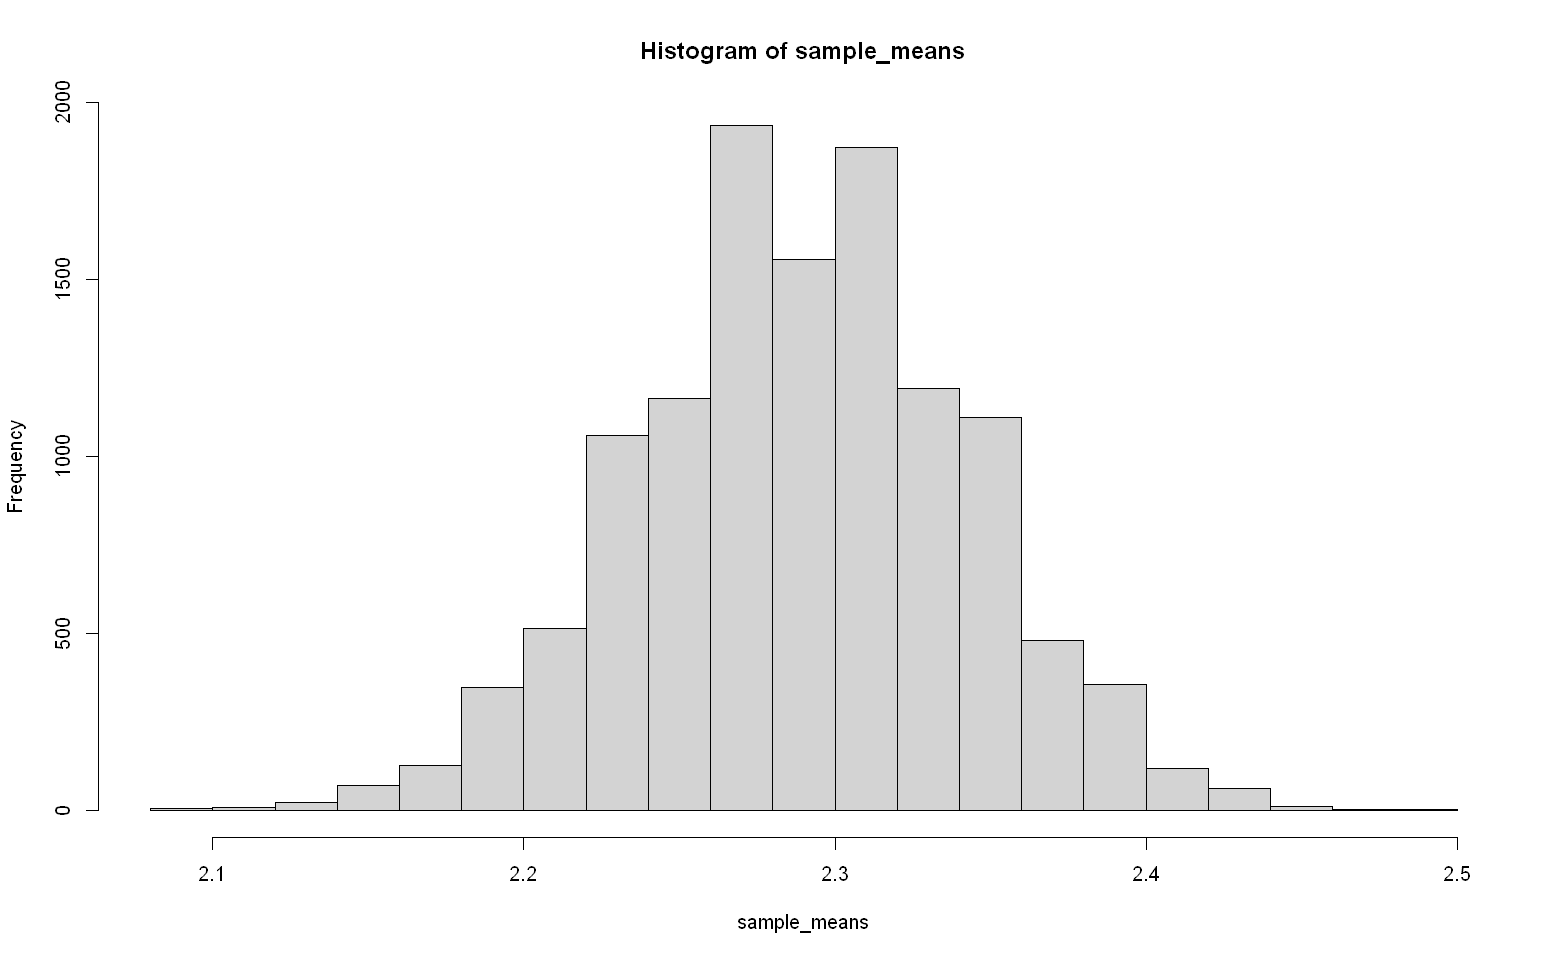

In [41]:
qq_mean(grade_F, n=n_F, iter=12000)
hist_mean(grade_F, n=n_F, iter=12000)

**Dla chłopców:**

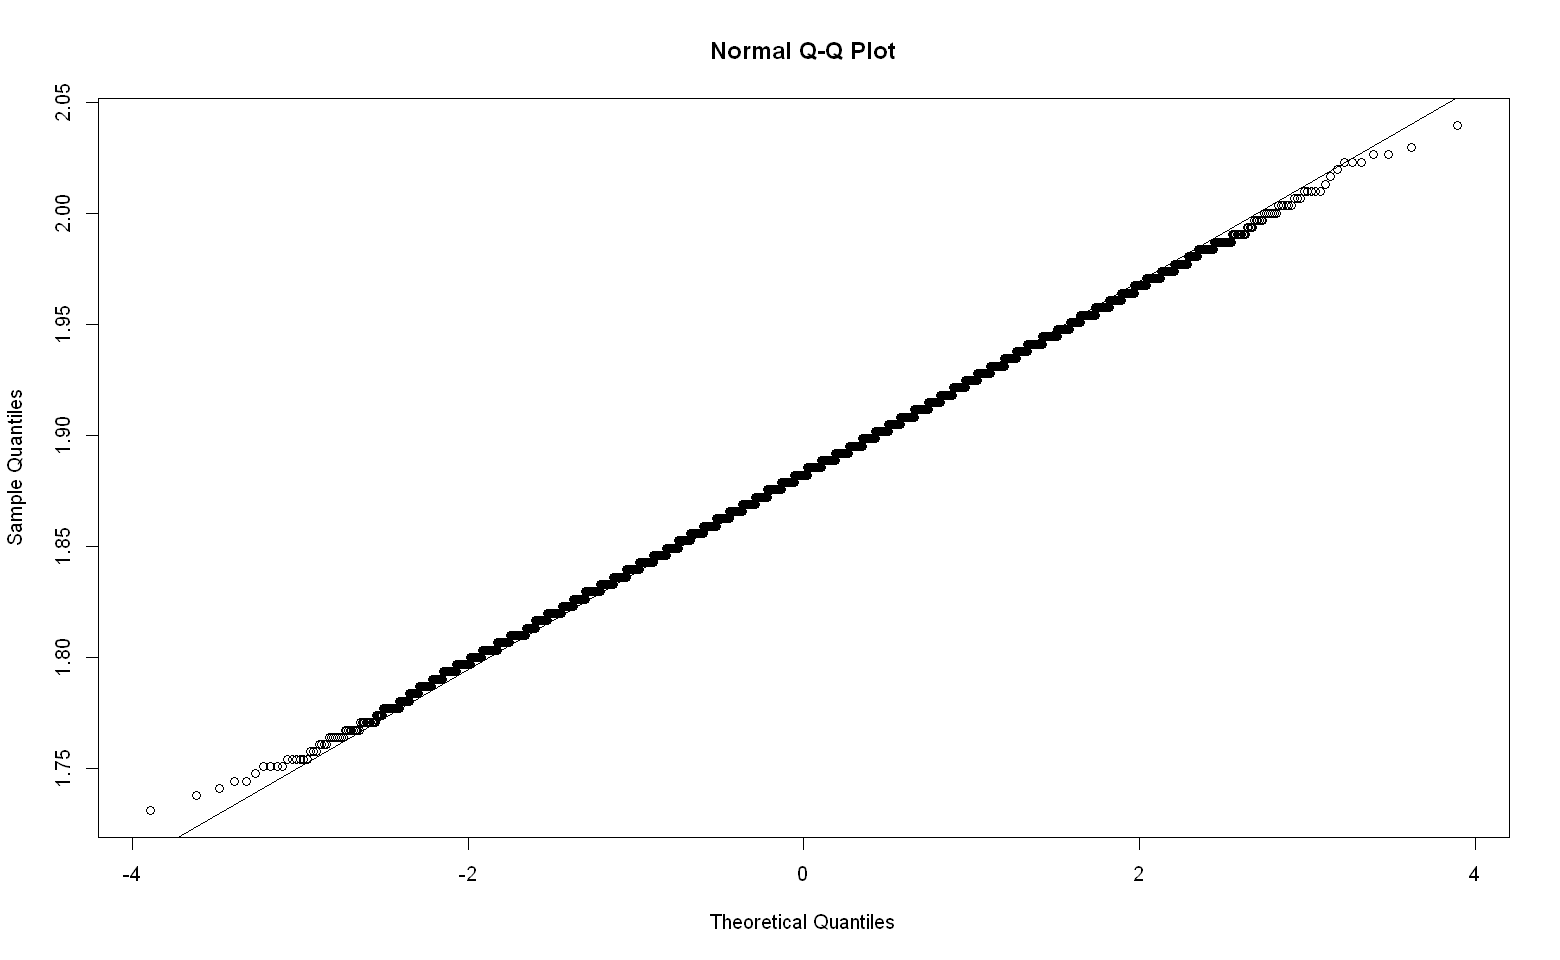

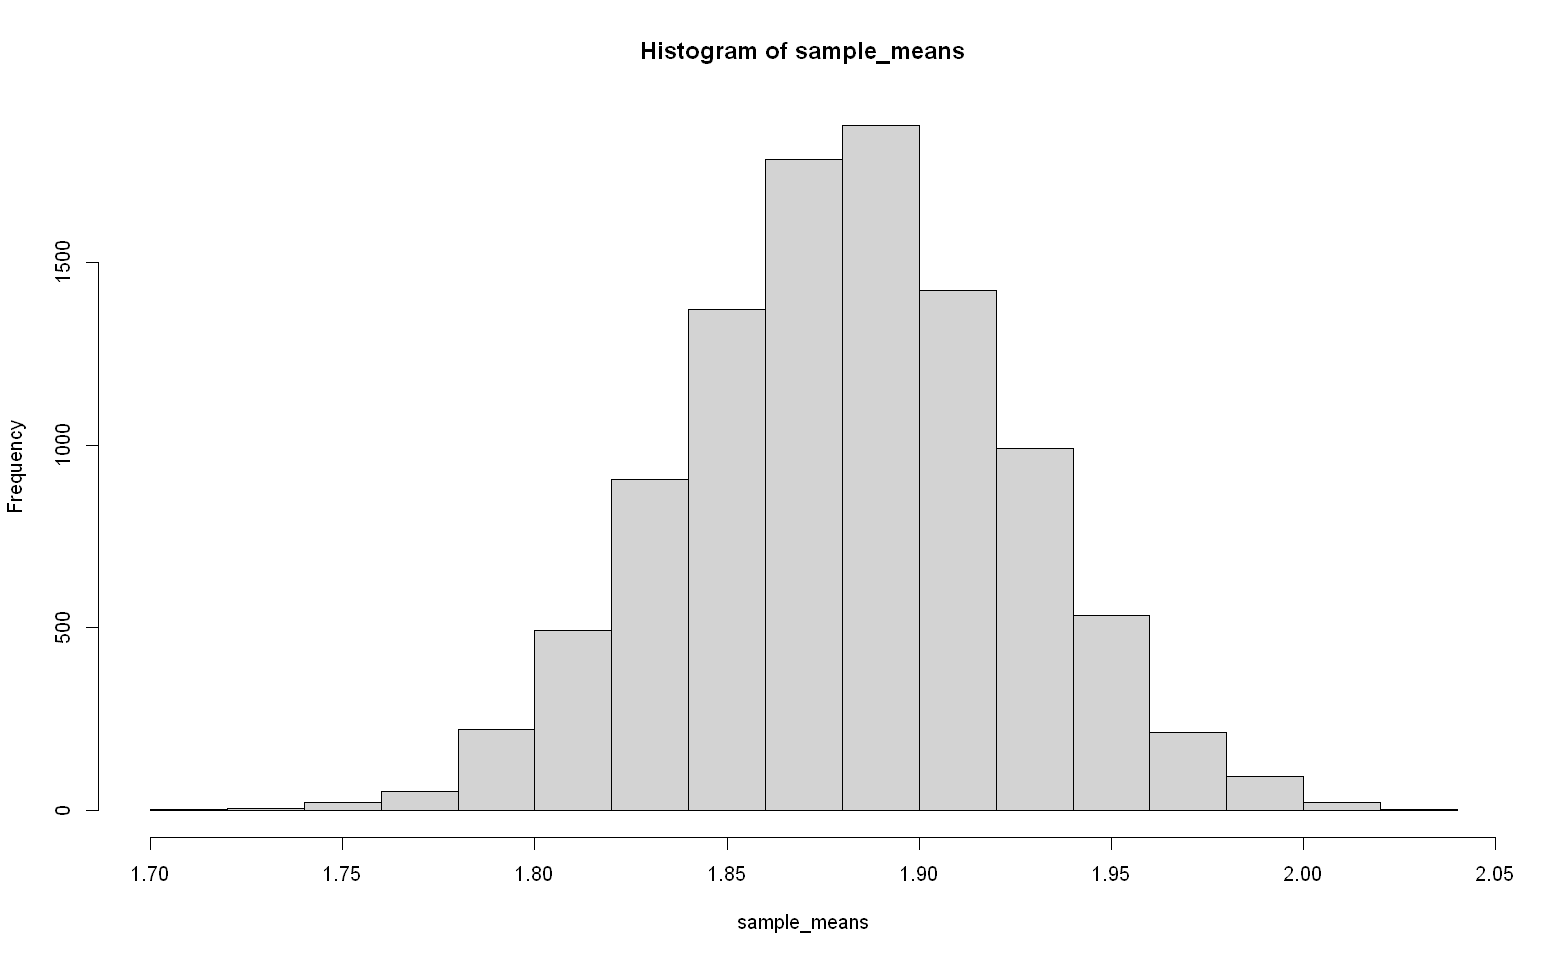

In [42]:
qq_mean(grade_M, n_M)
hist_mean(grade_M, n_M)

##### Wnioski
Zarówno w przypadku populacji dziewczyn, jak i chłopców rozkład średniej przy wielkości naszych próbek możemy przybliżyć rozkładem normalnym.

### 2. Równość wariancji w populacjach
##### Test F
+ $H_0: \sigma_M^2=\sigma_F^2$
+ $H_1: \sigma_M^2 > \sigma_F^2$
+ $\alpha=5\%$
+ Statystyka testowa $F= \frac{S_M^2}{S_F^2}$

In [43]:
#Statystyka testowa: 
F_t <- M_sd^2/F_sd^2
#P-wartość: P(F>F_t)
pf(F, df1=n_M-1, df2=n_F-1, lower.tail=FALSE) < 0.05

[1] FALSE

##### Wnioski
Nie ma podstaw do odrzucenia $H_0$, więc założenie o równości wariancji możemy uznać za zasadne.

### Test T dla dwóch populacji
+ Test dotyczy średniej klasy ocen.
+ Populacje:
    + $F$ - dziewczyny uczęszczające do szkoły
    + $M$ - analogiczna definicja dla chłopców
    
+ Poziom istotności testu $\alpha = 5%$
+ Hipoteza zerowa: $H_0 = \mu_F \leq \mu_M$
+ Hipoteza alternatywna: $H_1 = \mu_F > \mu_M$
+ Statystyka $T_{n_f+n_m-2} = \frac
{(\bar{x_F}-\bar{x_M})-0}
{\sqrt
{\frac
{(n_f-1)S_F^2+(n_m-1)S_M^2}{n_f+n_m-2}(\frac{1}{n_f}+\frac{1}{n_m}})}$

In [44]:
wariancja_laczna <- sqrt((((n_F-1)*F_sd^2 + (n_M-1)*M_sd^2)/(n_F+n_M-2))*(1/n_F+1/n_M))
T <- (F_mean-M_mean)/wariancja_laczna
p <- pt(-T, df=n_F+n_M-2) 

p < 0.05 #Test jednostronny
2*p < 0.05 #Test dwustronny

[1] TRUE

[1] TRUE

+ Decyzja: Odrzucamy $H_0$ na rzecz $H_1$ z prawdopodobieństem popełnienia błędu I-rodzaju równym $5\%$. Dodatkowo, pokazaliśmy, że test dwustronny miałby taki sam rezultat.

### Podsumowanie
Na podstawie analizowanego zbioru danych i odpowiednich testów statystycznych udowodniłam, że wśród uczniów będących na etapie edukacji niższym niż liceum:
+ dziewczyny średnio większą ilość razy korzystają z materiałów edukacyjnych
+ dziewczyny średnio lepiej się uczą niż chłopcy

Ponadto, analiza danych wykazała również, że uzyskiwana ocena jest silnie skorelowana liniowo z zaangażowaniem w proces uczenia się (tj. `RaisedHand`, `AnnouncementsViews`, `VisitedResources`), a szczególnie z częstością korzystania z materiałów edukacyjnych zapewnionych przez placówkę eduakcyjną.

### 3.3 Analiza innych czynników
Naturalnym wydaje się podejrzenie, że na wyniki w nauce ucznia wpływa liczba jego nieobecności. Narysujmy wykres:

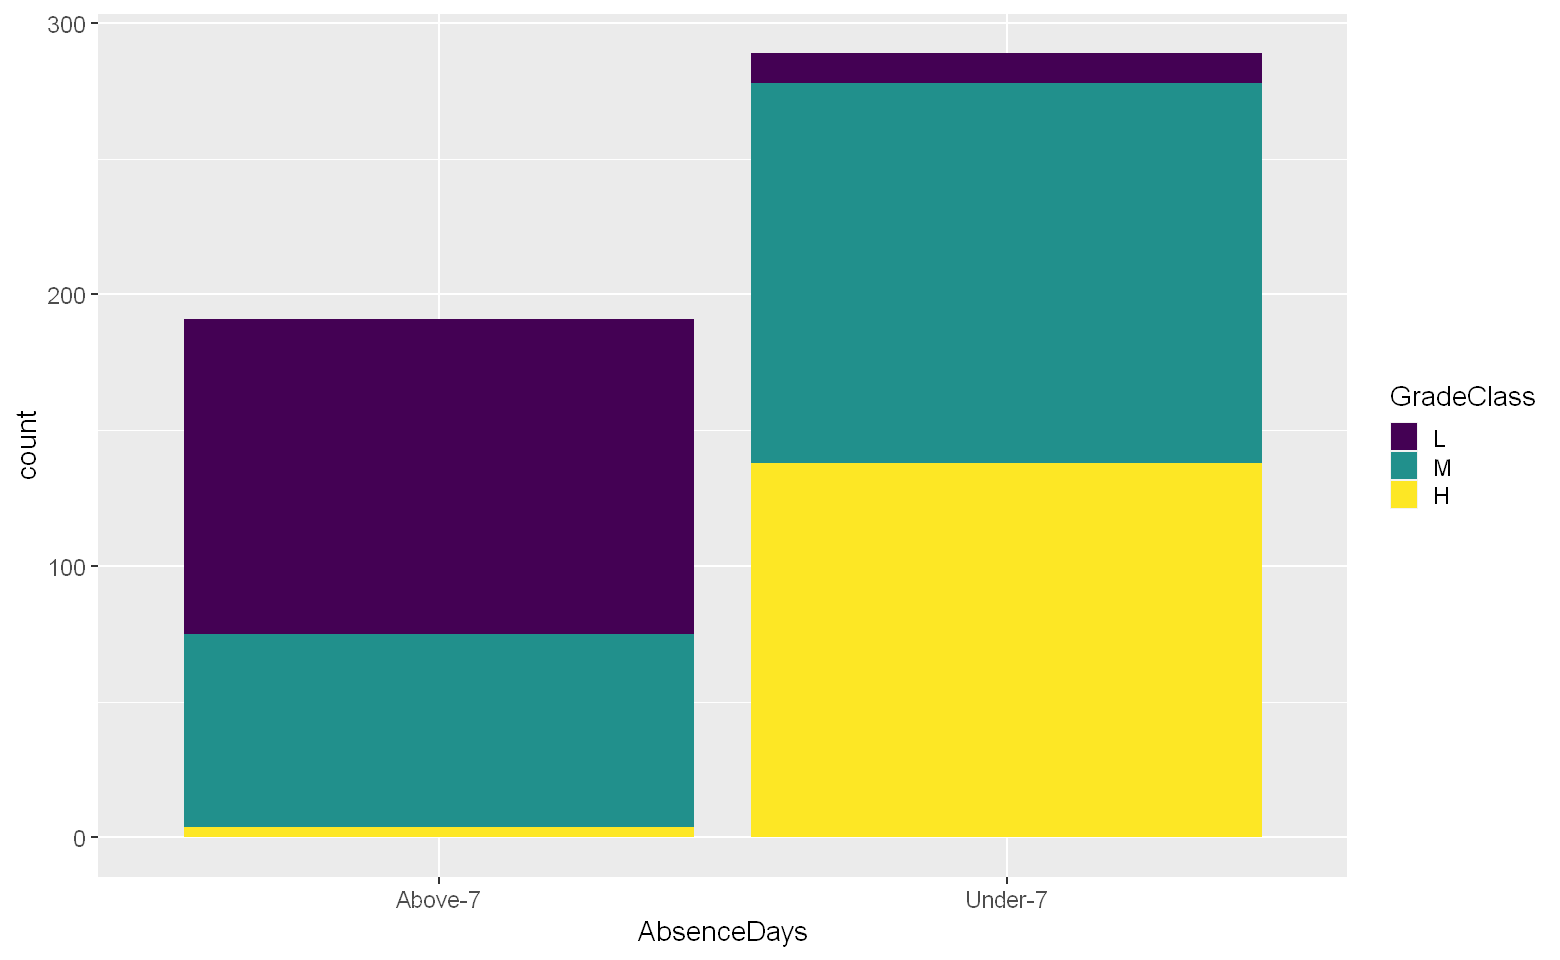

In [45]:
p1 <- ggplot(data, aes(x=AbsenceDays, fill=GradeClass)) + geom_bar() + theme_gray(base_size=17)
p1

##### Spostrzeżenia i wnioski
+ Wśród uczniów mających więcej niż siedem nieobecności bardzo mała liczba osób osiąga wynik z klasy `High`. Większość otrzymuje ocenę najgorszej klasy.

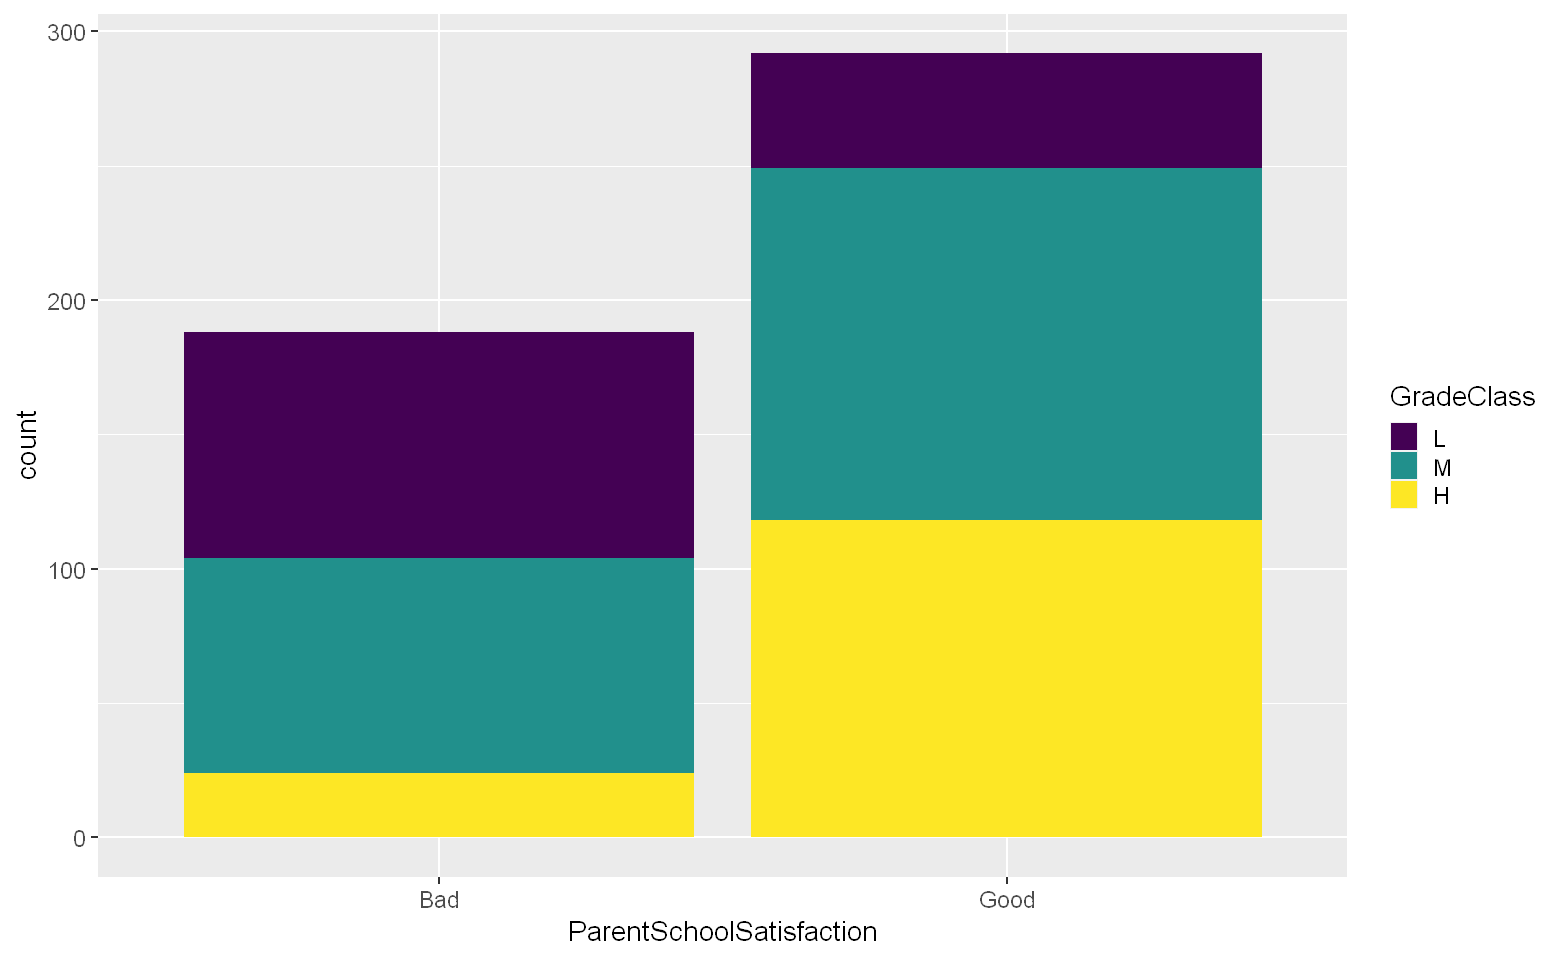

In [46]:
p1 <- ggplot(data, aes(x=ParentSchoolSatisfaction, fill=GradeClass)) + geom_bar() + theme_gray(base_size=17)
p1

##### Spostrzeżenia i wnioski
+ Rodzice określający swój poziom zadowolenia z placówki jako dobry, to w większości rodzice dzieci osiągających wyniki z klasy `Medium` i `High`.
+ Analogicznie w grupie rodziców niezadowolonych z placówki więcej dzieci osiąga wyniki z grupy `Low'.

Aby potwierdzić zabserwowaną na wykresach zależność `ParentSchoolSatisfaction` i `AbsenceDays` z `GradeClass` wykonamy dwa analogiczne testy $\chi^2$ na niezależność, oba na poziomie istotności $5\%$.
+ Hipoteza zerowa: $H_0:$ zmienne są niezależne
+ Hipoteza alternatynwa: $H_1:$ zmienne są zależne

In [47]:
#Najpierw zliczamy wystapienia zmiennych:
#Dla testu 1.:
table1 <- table(data$GradeClass, data$AbsenceDays)
#Dla testu 2.:
table2 <- table(data$GradeClass, data$ParentSchoolSatisfaction)

### Test dla `AbsenceDays` i `GradeClass`

In [48]:
t1 <- chisq.test(table1)

#### Wartości oczekiwane:

In [49]:
print(t1$expected)

   
     Above-7   Under-7
  L 50.53542  76.46458
  M 83.96042 127.03958
  H 56.50417  85.49583


Założenie testu $\forall E_i>5$ jest spełnione.

#### Wartości zaobserwowane:

In [50]:
t1$observed

   
    Above-7 Under-7
  L     116      11
  M      71     140
  H       4     138

#### Wynik testu:

In [51]:
t1


	Pearson's Chi-squared test

data:  table1
X-squared = 225.2, df = 2, p-value < 2.2e-16


**P-wartość jest mniejsza niż $0.05$, więc odrzucamy $H_0$ na rzecz $H_1$.**

### Test dla `ParentSchoolSatisfaction` i `GradeClass`

In [52]:
t2 <- chisq.test(table2)

#### Wartości oczekiwane:

In [53]:
print(t2$expected)

   
         Bad      Good
  L 49.74167  77.25833
  M 82.64167 128.35833
  H 55.61667  86.38333


Założenie testu $\forall E_i>5$ jest spełnione.

#### Wartości zaobserwowane:

In [54]:
t2$observed

   
    Bad Good
  L  84   43
  M  80  131
  H  24  118

#### Wynik testu:

In [55]:
t2


	Pearson's Chi-squared test

data:  table2
X-squared = 68.47, df = 2, p-value = 1.355e-15


**P-wartość jest mniejsza niż $0.05$, więc odrzucamy $H_0$ na rzecz $H_1$.**

## 4. Model regresji
+ Problem: przewidywanie klasy oceny ucznia (`GradeClass`) na podstawie dostępnych informacji
+ Mamy do czynienia z problemem wielokrotnej klasyfikacji (multinomial logistic regression).

In [56]:
#Dzielimy zbiór danych na dwa zbiory:
shuffled.data <- data[sample(nrow(data)),]
part <- round(n*0.6, digits=0)

train.data <- shuffled.data[1:part, ]
test.data <- shuffled.data[seq(part+1, nrow(data), by=1), ]

#Sprawdzenie czy podział jest prawidłowy:
nrow(train.data) + nrow(test.data) == nrow(data)

[1] TRUE

Z wykorzystaniem biblioteki `nnet` budujemy model regresji logistycznej z użyciem `train.data`. Zmienne wprowadzone dla modelu to te, które podczas analizy wydawały się być skorelowane z `GradeClass. ` 

In [57]:
model <- nnet::multinom(GradeClass ~ VisitedResources+RaisedHand+AnnouncementsViews+Gender+ParentSchoolSatisfaction+AbsenceDays, data = train.data)
summary(model)


# weights:  24 (14 variable)
initial  value 316.400339 
iter  10 value 183.954721
iter  20 value 162.158079
final  value 162.142373 
converged


Call:
nnet::multinom(formula = GradeClass ~ VisitedResources + RaisedHand + 
    AnnouncementsViews + Gender + ParentSchoolSatisfaction + 
    AbsenceDays, data = train.data)

Coefficients:
  (Intercept) VisitedResources RaisedHand AnnouncementsViews   GenderM
M   -3.119603       0.03735912 0.02582230         0.04144582 -1.006159
H   -8.545802       0.05046428 0.05179838         0.04914999 -1.397143
  ParentSchoolSatisfactionGood AbsenceDaysUnder-7
M                    0.8952831           2.634988
H                    1.5220174           5.036856

Std. Errors:
  (Intercept) VisitedResources RaisedHand AnnouncementsViews   GenderM
M   0.7441406       0.01178785 0.01464638         0.01448363 0.5787034
H   1.1628357       0.01408059 0.01656097         0.01638557 0.6658027
  ParentSchoolSatisfactionGood AbsenceDaysUnder-7
M                    0.4847026          0.5457141
H                    0.6151284          0.7859050

Residual Deviance: 324.2847 
AIC: 352.2847 

Sprawdźmy celność wyliczonych współczynników:

In [58]:
predicted.classes <- model %>% predict(test.data)

#Celność:
mean(as.numeric(predicted.classes) == as.numeric(test.data$GradeClass))

[1] 0.75

Udało się uzyskać model z celnościa na poziomie 75%.

## 5. Podsumowanie
Wyniki, które udało się uzyskać w tej analizie są bardzo ciekawe, jednak wymagają przeprowadzenia wykraczjących poza tę pracę dalszych badań na większej próbie. Aby móc efektywnie wykorzystać uzyskane rezultaty w uniwersalnym modelowaniu systemu edukacji, konieczne jest między innymi zbadanie wpływu regionu kulturowego, czy metod stosowanych przez daną placówkę na otrzymane wyniki. 

Niemniej, powyższa analiza pokazuje jak duży potencjał w kontekście badań nad optymalizacją uczenia się ma mierzenie fukncji behawioralnych ucznia.  Przeprowadzenie takiego badania lokalnie w obrębie pojedycznej placówki edukacyjnej może potencjalnie pomóc w wypunktowaniu słabych stron stosowanego systemu edukacji i zrozumieniu czynników wpływających na osiągane przez uczniów wyniki akademickie. Wreszcie analiza z uwzględnienim funkcji behawioralnych może stanowić świetną bazę do dalszej optymalizacji systemu uczenia się. 
